# Projeto para Empresa PProductions
## Desafio Lighthouse Indicium

---

## Parte 1: Análise Exploratória dos Dados (EDA)

---

### Introdução

Antes de explorar os dados, é interessante entender com o que trabalharemos nesse documento. Nosso **foco** é fazer a análise cinematográfica dos estudios PProductions para orientar qual tipo de filme deve ser o próximo a ser desenvolvido pelos mesmos.

A empresa disponibilisou sua database com as seguintes **informações**: Nome do filme, Ano de lançamento, Classificação etária, Tempo de duração, Gênero, Nota do IMDB, Overview do filme, Média ponderada de todas as críticas, Diretor, Ator/atriz #1, Ator/atriz #2, Ator/atriz #3, Ator/atriz #4, Número de votos, Faturamento

Para **complementar** a análise, o time de consultoria de dados da Indicium decidiu por complementar essas informações com a base de dados de todos os filmes e atores **indicados e ganhadores da cerimônia do Oscar**, que é o principal prémio anual da indústria cinematográfica. As informações dessa base de dados são: Ano do filme, Ano da cerimônia, Número da cerimônia, Categoria, Categoria específica, Nome, Filme, Ganhador (binário) 

---

### Importação e Análises Superfíciais

A análise exploratória dos dados começa com a importação das bibliotecas necessárias para a contrução do código.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
from collections import Counter
from collections import defaultdict
import re
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder

In [2]:
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "figure.figsize": (10,6),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.fontsize": 10
})

In [3]:
imdb=pd.read_csv("desafio_indicium_imdb.csv") 
oscar=pd.read_csv("the_oscar_award.csv")

In [4]:
print(f"O formato do conjunto de dados do IMDB é: \033[1m{imdb.shape[0]}\033[0m linhas e \033[1m{imdb.shape[1]}\033[0m colunas. "
      f"Enquanto o formato do conjunto de dados do Oscar é: \033[1m{oscar.shape[0]}\033[0m linhas e \033[1m{oscar.shape[1]}\033[0m colunas.")

O formato do conjunto de dados do IMDB é: 999 linhas e 16 colunas. Enquanto o formato do conjunto de dados do Oscar é: 11110 linhas e 8 colunas.


### Base de dados combinada

Para a realização das análises, utilizaremos uma base de dados que combina a base imdb e a base dos filmes indicados ao Oscar

In [5]:
def normalize_title(title):
    if pd.isna(title):
        return ""
    title = title.lower().strip()
    title = re.sub(r'[^a-z0-9 ]', '', title)
    title = re.sub(r'\s+', ' ', title)
    return title

oscar['film_norm'] = oscar['film'].apply(normalize_title)
oscar['name'] = oscar['name'].str.strip().str.lower()

imdb['Series_Title_norm'] = imdb['Series_Title'].apply(normalize_title)
imdb['Director'] = imdb['Director'].str.strip().str.lower()
for col in ['Star1','Star2','Star3','Star4']:
    imdb[col] = imdb[col].str.strip().str.lower()

def check_oscar_specific(film_norm, person=None, tipo="actor"):
    if tipo == "film":
        subset = oscar[(oscar['film_norm'] == film_norm) & 
                       (oscar['canon_category'] == "BEST PICTURE")]
    else:  # ator ou diretor
        subset = oscar[(oscar['film_norm'] == film_norm) & (oscar['name'] == person)]
    if subset.empty:
        return "No"
    elif subset['winner'].any():
        return "Won"
    else:
        return "Nominated"

imdb_oscar = imdb.copy()

imdb_oscar['Oscar_Film'] = imdb_oscar['Series_Title_norm'].apply(
    lambda x: check_oscar_specific(x, tipo="film"))

imdb_oscar['Director_Oscar'] = imdb_oscar.apply(
    lambda row: check_oscar_specific(row['Series_Title_norm'], row['Director'], tipo="actor"), axis=1)

for col in ['Star1','Star2','Star3','Star4']:
    imdb_oscar[col + '_Oscar'] = imdb_oscar.apply(
        lambda row: check_oscar_specific(row['Series_Title_norm'], row[col], tipo="actor"), axis=1)

imdb_oscar.to_csv("imdb_oscar.csv", index=False)

### Correções necessárias
#### Limpando e ajustando os dados

In [6]:
imdb_oscar[imdb_oscar.duplicated()]

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,...,Star4,No_of_Votes,Gross,Series_Title_norm,Oscar_Film,Director_Oscar,Star1_Oscar,Star2_Oscar,Star3_Oscar,Star4_Oscar


A base de dados combinados não apresenta valores duplicados

In [7]:
imdb_oscar.isnull().sum()

Unnamed: 0             0
Series_Title           0
Released_Year          0
Certificate          101
Runtime                0
Genre                  0
IMDB_Rating            0
Overview               0
Meta_score           157
Director               0
Star1                  0
Star2                  0
Star3                  0
Star4                  0
No_of_Votes            0
Gross                169
Series_Title_norm      0
Oscar_Film             0
Director_Oscar         0
Star1_Oscar            0
Star2_Oscar            0
Star3_Oscar            0
Star4_Oscar            0
dtype: int64

Corrigindo os valores faltantes da coluna "Certificate". Para essa correção, assumiu-se que todos os filmes sem classificação indicativa não tinham restrição de idade. Então, foram transformados em Universal rating (U).

In [8]:
imdb_oscar['Certificate'] = imdb_oscar['Certificate'].fillna('U')

Para os valores faltantes da coluna "Meta_score" decidiu-se utilizar a média dos valores existentes na coluna. Isso foi feito para evitar que esses valores atrapalhasem os futuros cálculos.

In [9]:
imdb_oscar['Meta_score'] = imdb_oscar['Meta_score'].fillna(imdb_oscar['Meta_score'].mean())

Corrigindo a coluna de faturamento "Gross"

In [10]:
imdb_oscar['Gross'] = (
    imdb_oscar['Gross']
    .str.replace(',', '', regex=False)  
    .astype('float64')                  
    .fillna(0)                          
)

Corrigindo a coluna de tempo de filme "Runtime"

In [11]:
imdb_oscar['Runtime'] = imdb_oscar['Runtime'].str.extract('(\d+)')
imdb_oscar = imdb_oscar[imdb_oscar['Runtime'].notna()]
imdb_oscar['Runtime'] = imdb_oscar['Runtime'].astype(int)

Corrigindo a coluna do ano de lançamento "Released_Year"

In [12]:
imdb_oscar['Released_Year'].value_counts()

Released_Year
2014    32
2004    31
2009    29
2013    28
2016    28
        ..
1920     1
1930     1
1922     1
1943     1
PG       1
Name: count, Length: 100, dtype: int64

Aqui podemos perceber que apenas um filme está sem a data de lançamento.

In [13]:
nome = ~imdb_oscar['Released_Year'].str.isnumeric()
sem_ano = imdb_oscar[nome]

print(sem_ano[['Series_Title', 'Released_Year']])

    Series_Title Released_Year
965    Apollo 13            PG


Como é apenas um filme que está sem data, podemos inserir essa data manualmente:

In [14]:
imdb_oscar.loc[imdb_oscar['Series_Title'] == 'Apollo 13', 'Released_Year'] = 1995

Verificando se temos algum valor Null na base de dados

In [15]:
imdb_oscar.isnull().sum()

Unnamed: 0           0
Series_Title         0
Released_Year        0
Certificate          0
Runtime              0
Genre                0
IMDB_Rating          0
Overview             0
Meta_score           0
Director             0
Star1                0
Star2                0
Star3                0
Star4                0
No_of_Votes          0
Gross                0
Series_Title_norm    0
Oscar_Film           0
Director_Oscar       0
Star1_Oscar          0
Star2_Oscar          0
Star3_Oscar          0
Star4_Oscar          0
dtype: int64

Verificação do tipo de dado de cada coluna

In [16]:
imdb_oscar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         999 non-null    int64  
 1   Series_Title       999 non-null    object 
 2   Released_Year      999 non-null    object 
 3   Certificate        999 non-null    object 
 4   Runtime            999 non-null    int64  
 5   Genre              999 non-null    object 
 6   IMDB_Rating        999 non-null    float64
 7   Overview           999 non-null    object 
 8   Meta_score         999 non-null    float64
 9   Director           999 non-null    object 
 10  Star1              999 non-null    object 
 11  Star2              999 non-null    object 
 12  Star3              999 non-null    object 
 13  Star4              999 non-null    object 
 14  No_of_Votes        999 non-null    int64  
 15  Gross              999 non-null    float64
 16  Series_Title_norm  999 non

A coluna de Released Year não está sendo tratada como int, então vamos fazer essa transformação

In [17]:
imdb_oscar['Released_Year'] = imdb_oscar['Released_Year'].astype(int)

Visualizando a nova base de dados:

In [18]:
imdb_oscar.head()

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,...,Star4,No_of_Votes,Gross,Series_Title_norm,Oscar_Film,Director_Oscar,Star1_Oscar,Star2_Oscar,Star3_Oscar,Star4_Oscar
0,1,The Godfather,1972,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,francis ford coppola,...,diane keaton,1620367,134966411.0,the godfather,Won,Nominated,Won,Nominated,Nominated,No
1,2,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,christopher nolan,...,michael caine,2303232,534858444.0,the dark knight,No,No,No,Won,No,No
2,3,The Godfather: Part II,1974,A,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,francis ford coppola,...,diane keaton,1129952,57300000.0,the godfather part ii,Won,Won,Nominated,Won,No,No
3,4,12 Angry Men,1957,U,96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,sidney lumet,...,john fiedler,689845,4360000.0,12 angry men,Nominated,Nominated,No,No,No,No
4,5,The Lord of the Rings: The Return of the King,2003,U,201,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,peter jackson,...,orlando bloom,1642758,377845905.0,the lord of the rings the return of the king,Won,Won,No,No,No,No


In [19]:
print(f"O formato do conjunto de dados combinados é: \033[1m{imdb_oscar.shape[0]}\033[0m linhas e \033[1m{imdb_oscar.shape[1]}\033[0m colunas. ")

O formato do conjunto de dados combinados é: 999 linhas e 23 colunas. 


### Visualização rápida de dados

#### Estatísticas descritivas das variáveis numéricas

In [20]:
imdb_oscar.describe()

,Unnamed: 0,Released_Year,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
count,999.000000,999.000000,999.000000,999.000000,999.000000,9.990000e+02,9.990000e+02
mean,500.000000,1991.218218,122.871872,7.947948,77.969121,2.716214e+05,5.656510e+07
std,288.530761,23.297166,28.101227,0.272290,11.367570,3.209126e+05,1.032860e+08
min,1.000000,1920.000000,45.000000,7.600000,28.000000,2.508800e+04,0.000000e+00
25%,250.500000,1976.000000,103.000000,7.700000,72.000000,5.547150e+04,4.422285e+05
50%,500.000000,1999.000000,119.000000,7.900000,77.969121,1.383560e+05,1.068028e+07
75%,749.500000,2009.000000,137.000000,8.100000,85.500000,3.731675e+05,6.157656e+07
max,999.000000,2020.000000,321.000000,9.200000,100.000000,2.303232e+06,9.366622e+08


A partir dessas informações, temos:

- Características:
    - Temos a **cobertura de 100 anos** no mundo do cinema, de 1920 a 2020.
    - A mediana do ano de lançamento dos filmes é **1999**.
    - A mediana do tempo de duração é **119 minutos**. Mas temos outliers grandes como o menor filme, com 45 minutos, e o maior filme, de 321 minutos.
- Críticas:
    - A base apresenta filmes com uma média de 7.95 no IMDb e 77.96 no Metascore - **Filmes são bem avaliados por ambas as críticas e tem sua base média próxima a 8**
    - O intervalo das notas é de 7.6 à 9.2 para o IMDb e 28 à 100 no Metascore - **A visão sobre os filmes pode divergir bastante entre as duas críticas - Para o IMDB esses filmes são considerados filmes com médias muitos boas, enquanto para o Metascore temos filmes com notas bem extremas**
        - O desvio-padrão está muito próximo da média para o IMDB, enquando existe uma divergência maior para o Metascore
- Popularidade:
    - A média do número de votos é **271 mil**.
    - Tivemos um filme com **2,3 milhões de votos**.
    - Temos uma distribuição bastante **assimétrica** de bilheteria, com média de 56 milhões enquanto a mediana é 10,6 milhões.

###### Principais insights:
- Todos os filmes são bem avaliados (nota maior de 7.6 no IMDb).
- A maior parte dos filmes está concentrada entre 1970 e 2020.
- A duração dos filmes usual é entre 1h40 e 2h20.
- Existe uma discrepância entre crítica e público, pois existem filmes muito populares que nem nota baixa dos críticos.

### Análises

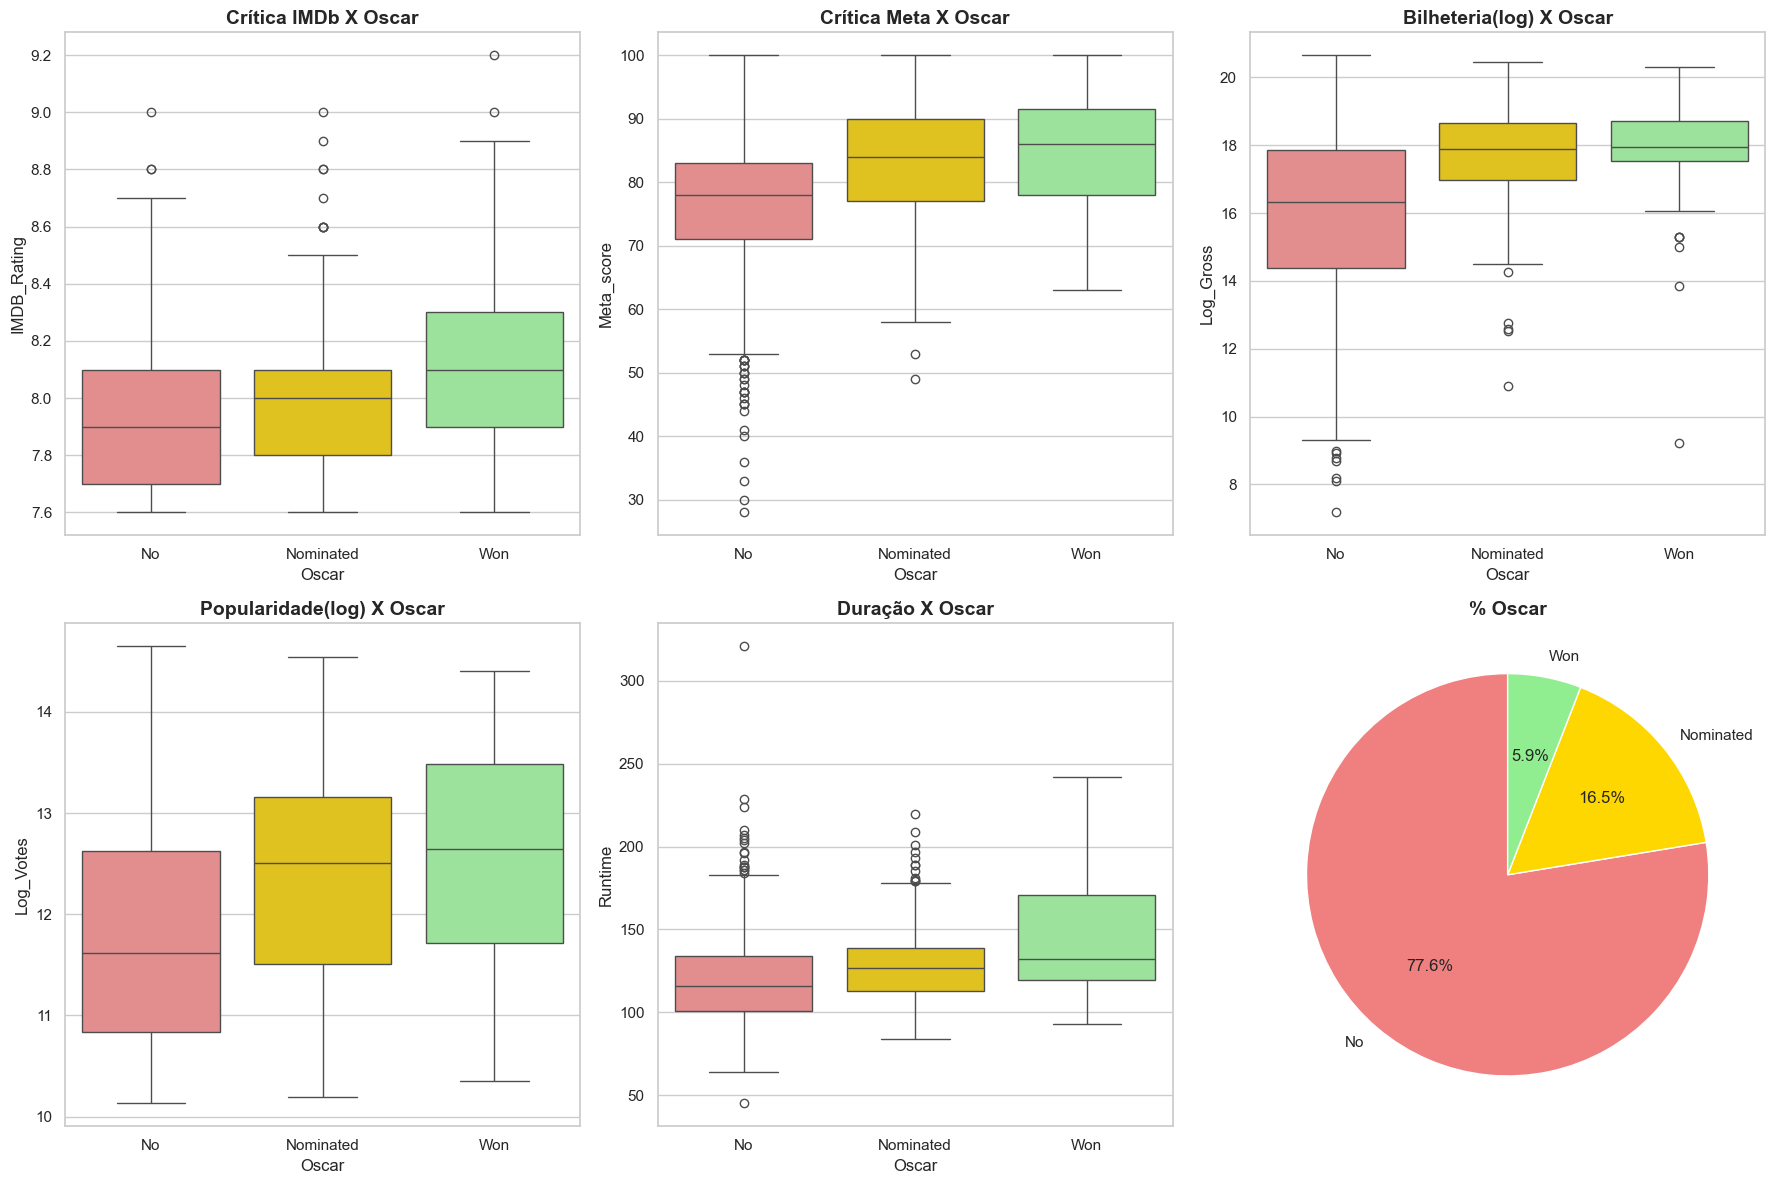

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

oscar_order = ['No', 'Nominated', 'Won']
colors = ['lightcoral', 'gold', 'lightgreen']

sns.boxplot(data=imdb_oscar, x='Oscar_Film', y='IMDB_Rating', 
            order=oscar_order, hue="Oscar_Film", legend=False,
            palette=dict(zip(oscar_order, colors)), ax=axes[0,0])
axes[0,0].set_title('Crítica IMDb X Oscar', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Oscar')

sns.boxplot(data=imdb_oscar.dropna(subset=['Meta_score']), 
            x='Oscar_Film', y='Meta_score', 
            order=oscar_order, hue="Oscar_Film", legend=False,
            palette=dict(zip(oscar_order, colors)), ax=axes[0,1])
axes[0,1].set_title('Crítica Meta X Oscar', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Oscar')

gross_data = imdb_oscar.dropna(subset=['Gross']).copy()
gross_data = gross_data[gross_data['Gross'] > 0]   # evita log(0)
gross_data['Log_Gross'] = np.log(gross_data['Gross'])
sns.boxplot(data=gross_data, x='Oscar_Film', y='Log_Gross',
            order=oscar_order, hue="Oscar_Film", legend=False,
            palette=dict(zip(oscar_order, colors)), ax=axes[0,2])
axes[0,2].set_title('Bilheteria(log) X Oscar', fontsize=14, fontweight='bold')
axes[0,2].set_xlabel('Oscar')

votes_data = imdb_oscar.dropna(subset=['No_of_Votes']).copy()
votes_data = votes_data[votes_data['No_of_Votes'] > 0]   # evita log(0)
votes_data['Log_Votes'] = np.log(votes_data['No_of_Votes'])
sns.boxplot(data=votes_data, x='Oscar_Film', y='Log_Votes',
            order=oscar_order, hue="Oscar_Film", legend=False,
            palette=dict(zip(oscar_order, colors)), ax=axes[1,0])
axes[1,0].set_title('Popularidade(log) X Oscar', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Oscar')

sns.boxplot(data=imdb_oscar.dropna(subset=['Runtime']), 
            x='Oscar_Film', y='Runtime',
            order=oscar_order, hue="Oscar_Film", legend=False,
            palette=dict(zip(oscar_order, colors)), ax=axes[1,1])
axes[1,1].set_title('Duração X Oscar', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Oscar')

oscar_counts = imdb_oscar['Oscar_Film'].value_counts()
axes[1,2].pie(oscar_counts.values, labels=oscar_counts.index, autopct='%1.1f%%',
             colors=colors, startangle=90)
axes[1,2].set_title('% Oscar', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


#### Análise de Progressão

In [22]:
progression = imdb_oscar.groupby('Oscar_Film')[['IMDB_Rating','Meta_score','Gross','No_of_Votes','Runtime']].mean()
progression = progression.reindex(oscar_order)
print(progression.round(2))

            IMDB_Rating  Meta_score        Gross  No_of_Votes  Runtime
Oscar_Film                                                            
No                 7.93       76.59  47329519.17    232678.76   119.58
Nominated          7.98       82.11  85776152.35    376149.67   130.38
Won                8.13       84.56  96188034.14    490831.68   145.08


###### Insights:
- Filmes que ganharam Oscars tem uma média de críticas visivelmente **superior** a aqueles que não ganharam ou foram apenas nomeados
- Filmes vencedores tem quase o **dobro de faturamento** do que filmes que não foram indicados.
    - Filmes que foram sucesso comercial tem mais chance de concorrerem a cerimônia
- As pessoas tendem a votar muito mais em filmes populares
- Os filmes vencedores tendem a serem mais **longos**

#### Incrementos Relativos

In [23]:
baseline = progression.loc['No']
for category in ['Nominated', 'Won']:
    increment = ((progression.loc[category] - baseline) / baseline * 100).round(1)
    print(f"\n{category} X No:")
    for col in increment.index:
        if not pd.isna(increment[col]):
            print(f"  {col}: {increment[col]:+.1f}%")


Nominated X No:
  IMDB_Rating: +0.7%
  Meta_score: +7.2%
  Gross: +81.2%
  No_of_Votes: +61.7%
  Runtime: +9.0%

Won X No:
  IMDB_Rating: +2.5%
  Meta_score: +10.4%
  Gross: +103.2%
  No_of_Votes: +110.9%
  Runtime: +21.3%


###### Insights:
- Observa-se um **aumento** consistente em **todas as métricas** à medida que o filme evolui de “Não indicado” para “Indicado” e de “Não indicado” para “Vencedor”
- O impacto mais expressivo ocorre em Gross e Número de Votos, sugerindo **forte relação** entre sucesso financeiro/atenção do público e reconhecimento na premiação.
- Avaliações do público (IMDB_Rating) e da crítica (Meta_score) também aumentam, embora de forma mais moderada, indicando que o prestígio crítico contribui, mas não é o único fator determinante para a vitória.
- Filmes vencedores tendem a ter **maior duração**, o que pode refletir preferência da indústria por narrativas mais complexas ou elaboradas.

### Outras Análises

#### Top Diretores

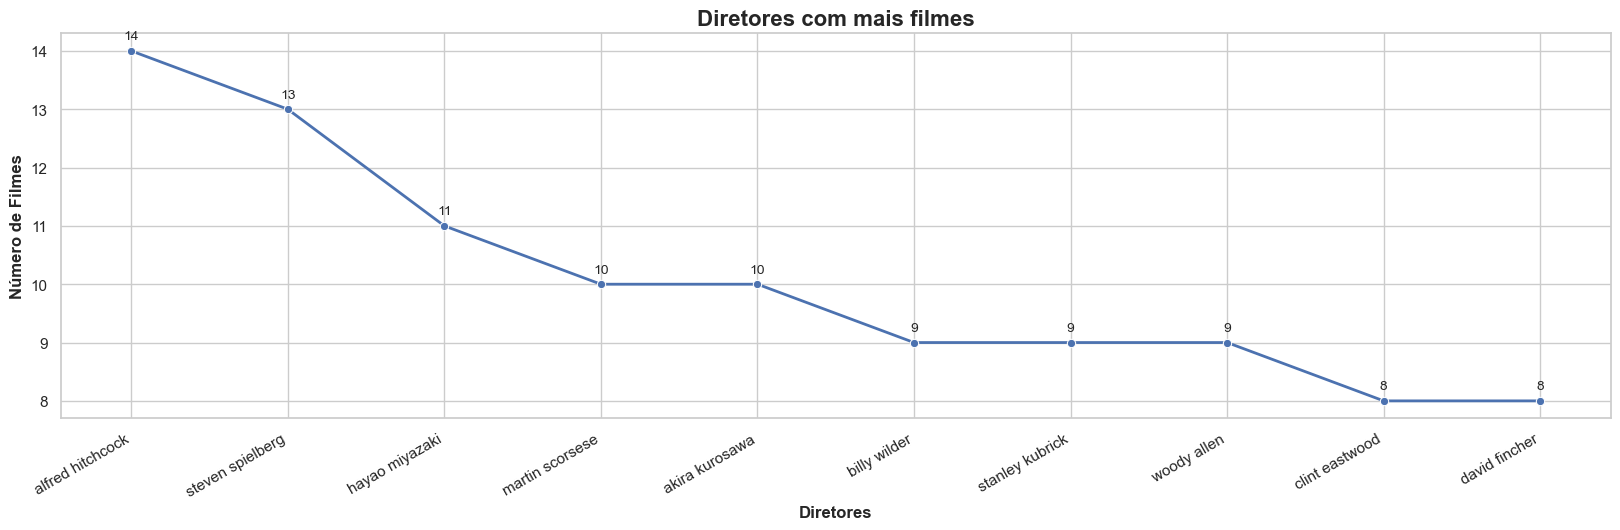

In [24]:
top_directors = imdb_oscar['Director'].value_counts()[:10]

fig, axs = plt.subplots(figsize=(20,5))

g = sns.lineplot(
    x=top_directors.index,
    y=top_directors.values,
    marker='o',
    linewidth=2
)

g.set_title("Diretores com mais filmes", weight="bold", fontsize=16)
g.set_xlabel("Diretores", fontsize=12, weight="bold")
g.set_ylabel("Número de Filmes", fontsize=12, weight="bold")

plt.xticks(rotation=30, ha='right')

for x, y in zip(top_directors.index, top_directors.values):
    g.text(x, y + 0.2, f"{y}", ha='center', fontsize=10)

plt.show()

#### Top Atores

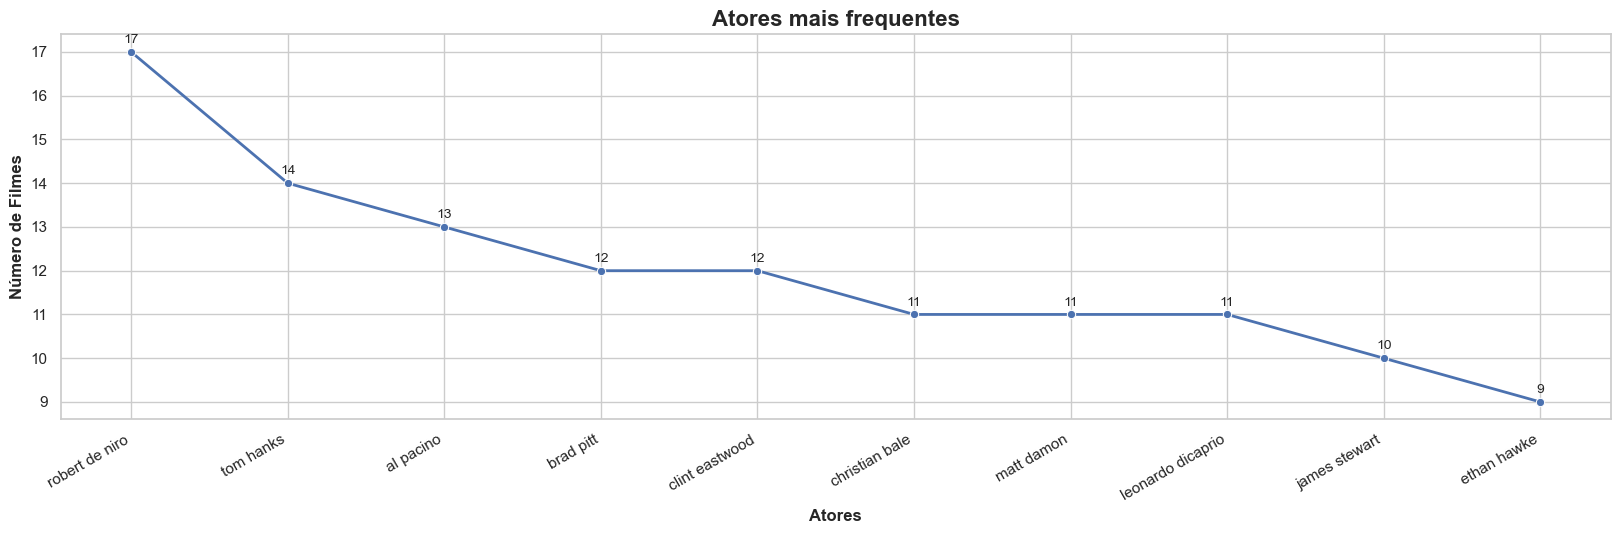

In [25]:
top_atores = imdb_oscar[['Star1','Star2','Star3','Star4']].stack().value_counts()[:10]

fig, axs = plt.subplots(figsize=(20,5))

g = sns.lineplot(
    x=top_atores.index,
    y=top_atores.values,
    marker='o',
    linewidth=2
)

g.set_title("Atores mais frequentes", weight="bold", fontsize=16)
g.set_xlabel("Atores", fontsize=12, weight="bold")
g.set_ylabel("Número de Filmes", fontsize=12, weight="bold")

plt.xticks(rotation=30, ha='right')

for x, y in zip(top_atores.index, top_atores.values):
    g.text(x, y + 0.2, f"{y}", ha='center', fontsize=10)

plt.show()

#### Gêneros

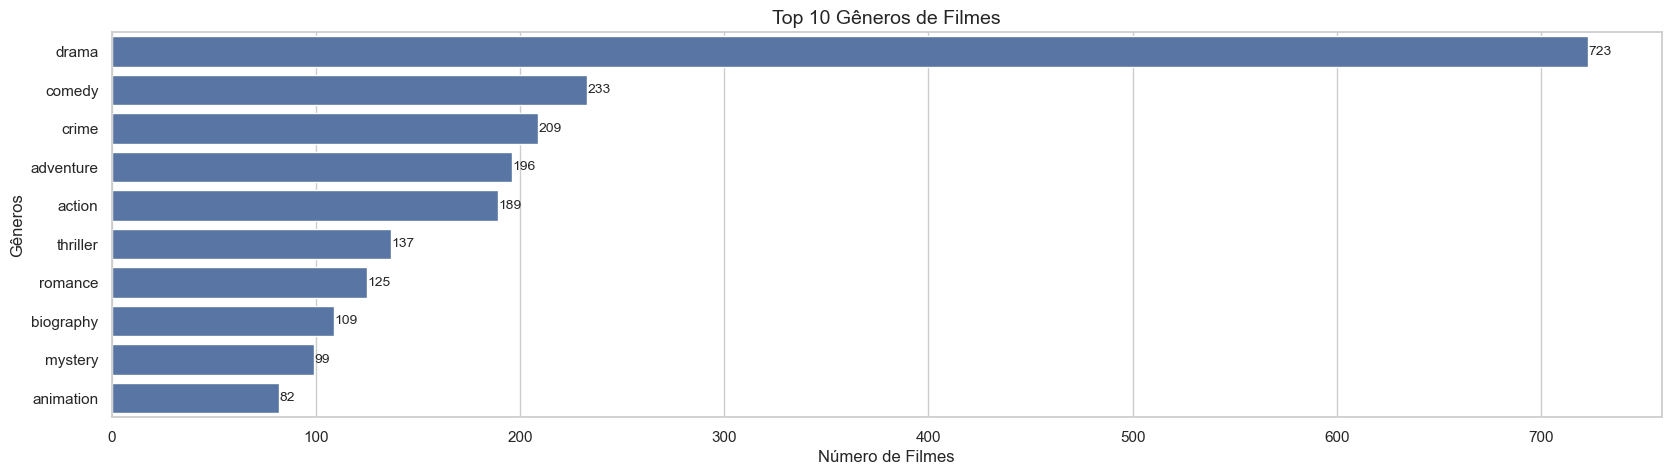

In [26]:
genres = (g.strip().lower() for x in imdb_oscar['Genre'] for g in x.split(','))
x, y = zip(*Counter(genres).most_common(10))

plt.figure(figsize=(20, 5))
ax = sns.barplot(x=y, y=x)

ax.set(
    xlabel="Número de Filmes",
    ylabel="Gêneros",
    title="Top 10 Gêneros de Filmes"
)

for i, v in enumerate(y):
    ax.text(v + 0.2, i, str(v), va="center", fontsize=10)

plt.show()

#### Top 5 Filmes por indicação do Oscar

In [27]:
for status in oscar_order:
    print(f"\n {status.upper()} X Crítica IMDb")
    top_films = (imdb_oscar[imdb_oscar['Oscar_Film']==status]
                .nlargest(5, 'IMDB_Rating')[['Series_Title','IMDB_Rating','Meta_score','Gross']])
    
    for idx, row in top_films.iterrows():
        gross_str = f"${row['Gross']:,.0f}" if not pd.isna(row['Gross']) else "N/A"
        meta_str = f"{row['Meta_score']:.0f}" if not pd.isna(row['Meta_score']) else "N/A"
        print(f"  {row['Series_Title']}: IMDb {row['IMDB_Rating']}, Meta {meta_str}, Faturamento {gross_str}")



 NO X Crítica IMDb
  The Dark Knight: IMDb 9.0, Meta 84, Faturamento $534,858,444
  Fight Club: IMDb 8.8, Meta 66, Faturamento $37,030,102
  Il buono, il brutto, il cattivo: IMDb 8.8, Meta 90, Faturamento $6,100,000
  The Matrix: IMDb 8.7, Meta 73, Faturamento $171,479,930
  Goodfellas: IMDb 8.7, Meta 90, Faturamento $46,836,394

 NOMINATED X Crítica IMDb
  12 Angry Men: IMDb 9.0, Meta 96, Faturamento $4,360,000
  Pulp Fiction: IMDb 8.9, Meta 94, Faturamento $107,928,762
  Inception: IMDb 8.8, Meta 74, Faturamento $292,576,195
  The Lord of the Rings: The Fellowship of the Ring: IMDb 8.8, Meta 92, Faturamento $315,544,750
  The Lord of the Rings: The Two Towers: IMDb 8.7, Meta 87, Faturamento $342,551,365

 WON X Crítica IMDb
  The Godfather: IMDb 9.2, Meta 100, Faturamento $134,966,411
  The Godfather: Part II: IMDb 9.0, Meta 90, Faturamento $57,300,000
  The Lord of the Rings: The Return of the King: IMDb 8.9, Meta 94, Faturamento $377,845,905
  Schindler's List: IMDb 8.9, Meta 94, 

##### Insights:
- Avaliação do público (IMDB Rating) é alta em todos os grupos, mas aumenta levemente do grupo No → Nominated → Won.
- Avaliação crítica (Meta_score) é mais consistente e elevada entre indicados e vencedores, sugerindo que a crítica tem forte influência nas premiações.
- Gross mostra que blockbusters podem ou não ser indicados ou vencedores: filmes de grande bilheteria aparecem em todos os grupos, mas vencedores tendem a equilibrar prestígio e faturamento.
- Evolução qualitativa: ao passar de No → Nominated → Won, os filmes tendem a ser mais consistentes em qualidade e reconhecimento crítico, enquanto a bilheteria é um fator secundário.

#### Filmes mais votados no IMDb

In [28]:
mais_votados= imdb_oscar.sort_values(['No_of_Votes'], ascending = False)

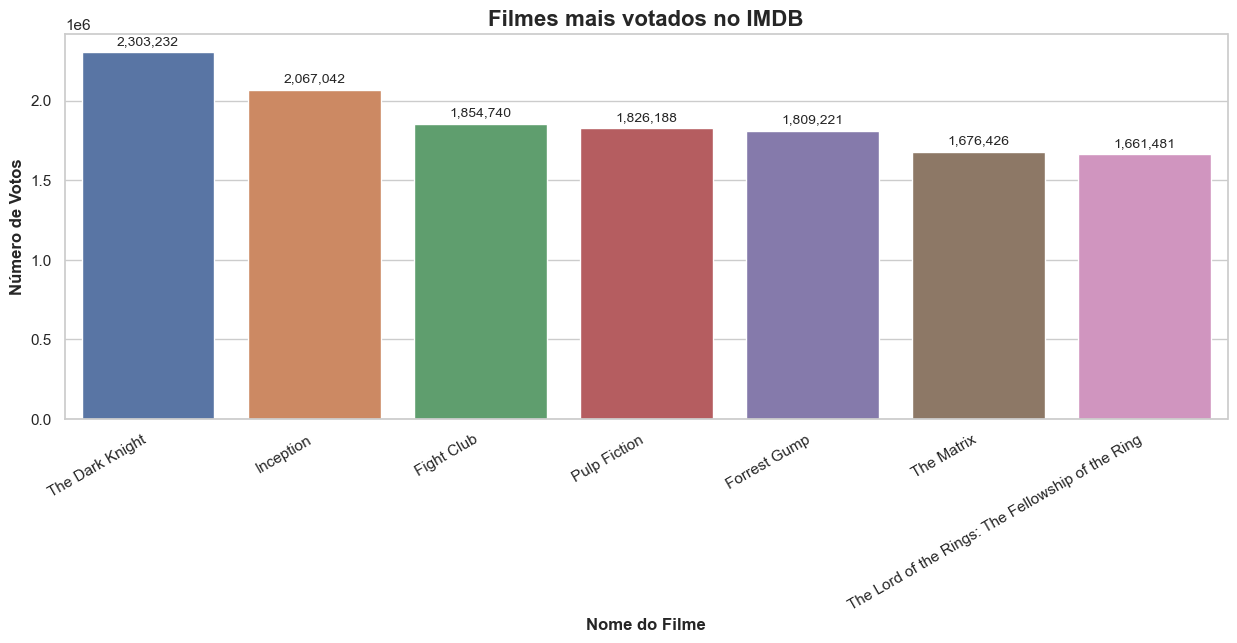

In [29]:
fig, axs = plt.subplots(figsize=(15,5))

g = sns.barplot(
    x='Series_Title',
    y='No_of_Votes',
    data=mais_votados[:7],
    hue='Series_Title',
    dodge=False,
    legend=False
)

g.set_title("Filmes mais votados no IMDB", weight="bold", fontsize=16)
g.set_xlabel("Nome do Filme", fontsize=12, weight="bold")
g.set_ylabel("Número de Votos", fontsize=12, weight="bold")

for index, value in enumerate(mais_votados['No_of_Votes'][:7]):
    g.text(index, value + 50000, f'{value:,}', ha='center', fontsize=10)

plt.xticks(rotation=30, ha='right')
plt.show()

#### Faturamento dos filmes mais votados

##### Filmes sem informação de faturamento

In [30]:
num_filmes_zero = imdb_oscar.loc[imdb_oscar['Gross'] == 0].shape[0]
print(f"O número de filmes sem informação de faturamento é {num_filmes_zero}.")

O número de filmes sem informação de faturamento é 169.


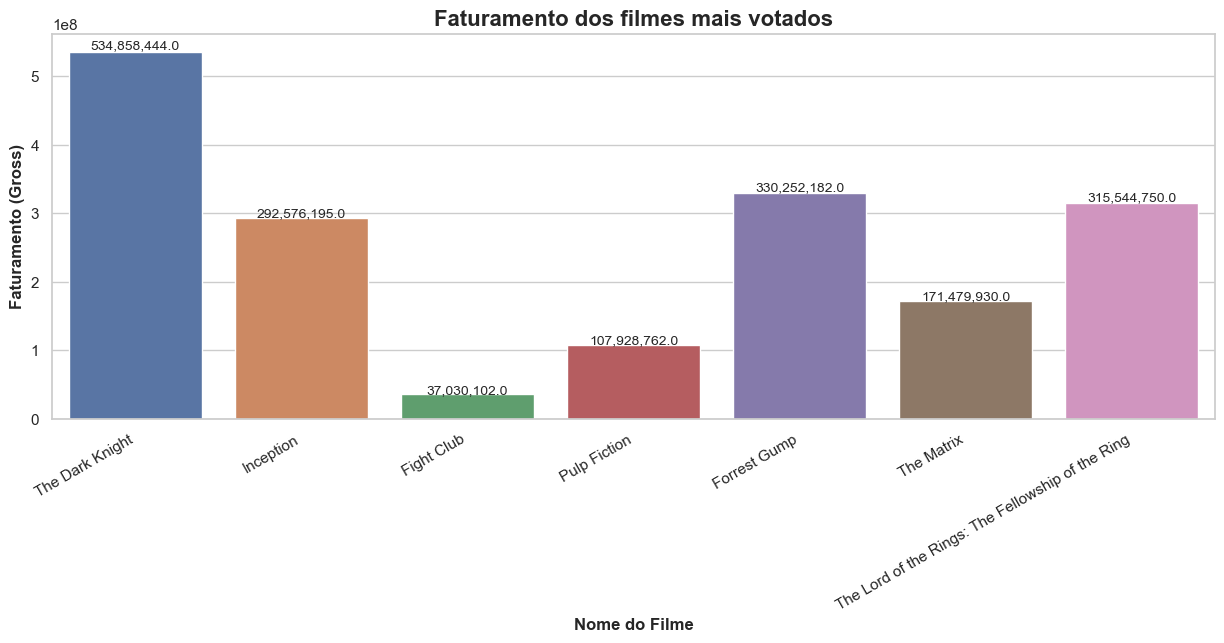

In [31]:
fig, axs = plt.subplots(figsize=(15,5))

g = sns.barplot(
    x='Series_Title',
    y='Gross',
    data=mais_votados[:7],
    hue='Series_Title',
    dodge=False,
    legend=False
)

g.set_title("Faturamento dos filmes mais votados", weight="bold", fontsize=16)
g.set_xlabel("Nome do Filme", fontsize=12, weight="bold")
g.set_ylabel("Faturamento (Gross)", fontsize=12, weight="bold")

for index, value in enumerate(mais_votados['Gross'][:7]):
    g.text(index, value + value*0.01, f'{value:,}', ha='center', fontsize=10)  # ajusta posição do texto

plt.xticks(rotation=30, ha='right')

plt.show()

#### Filmes com maior faturamento

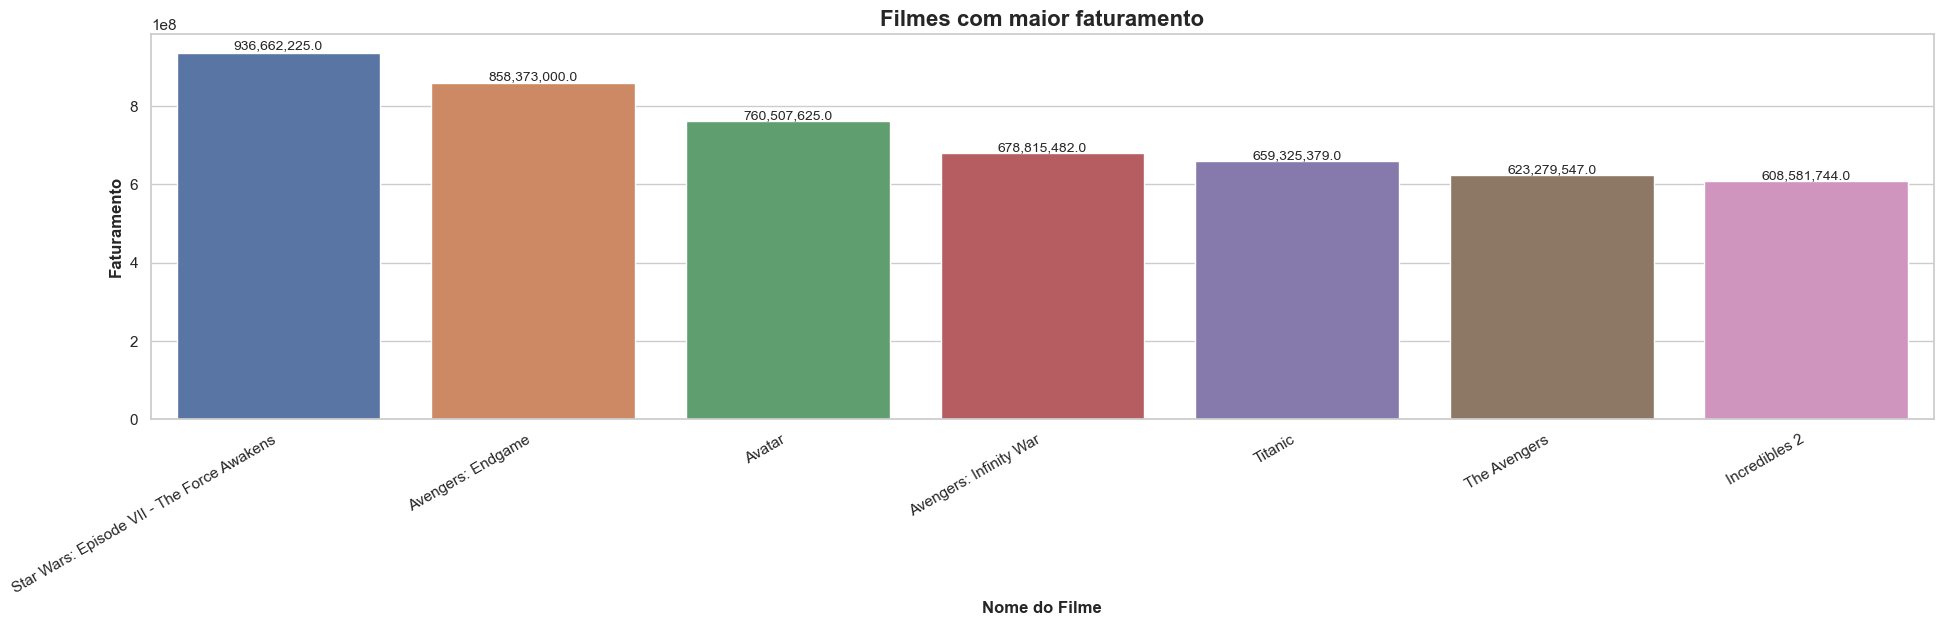

In [32]:
maior_fat = imdb_oscar.sort_values('Gross', ascending=False)

fig, axs = plt.subplots(figsize=(23,5))

g = sns.barplot(
    x='Series_Title',
    y='Gross',
    data=maior_fat[:7],
    hue='Series_Title',
    dodge=False,
    legend=False
)

g.set_title("Filmes com maior faturamento", weight="bold", fontsize=16)
g.set_xlabel("Nome do Filme", fontsize=12, weight="bold")
g.set_ylabel("Faturamento", fontsize=12, weight="bold")

for index, value in enumerate(maior_fat['Gross'][:7]):
    g.text(index, value + value*0.01, f'{value:,}', ha='center', fontsize=10) 


plt.xticks(rotation=30, ha='right')

plt.show()

#### Atores mais votados

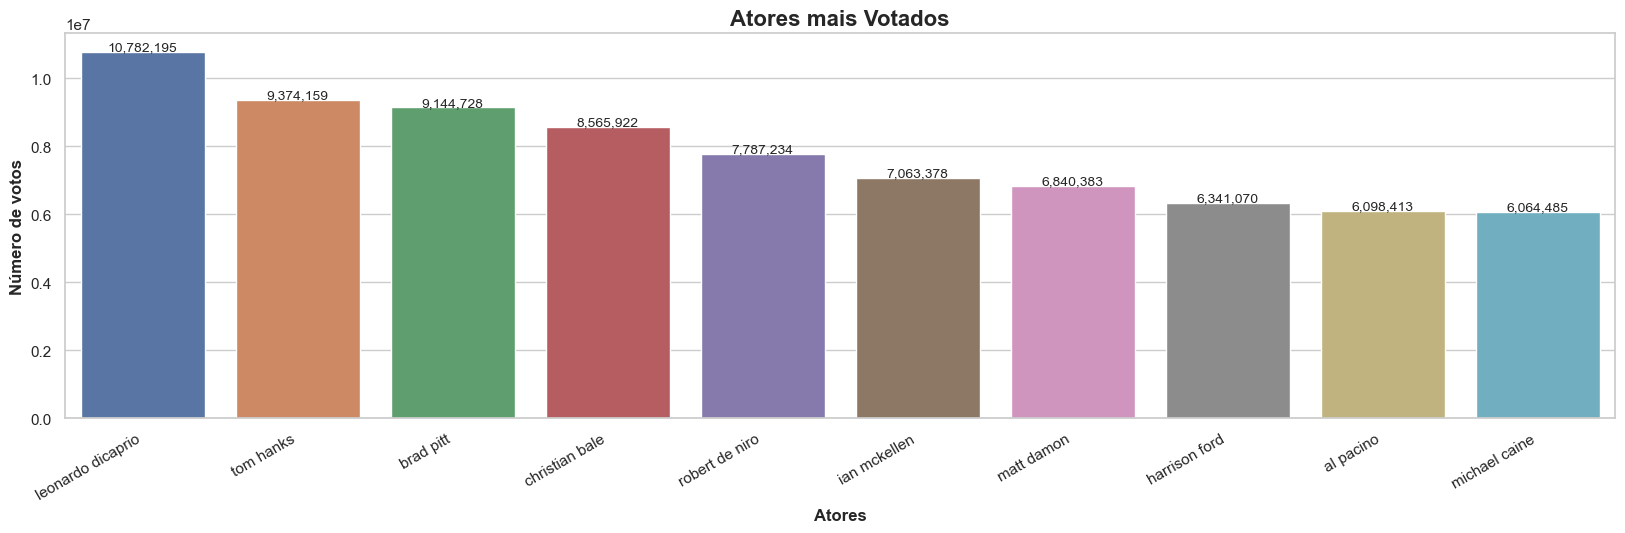

In [33]:
stars = imdb_oscar[['Star1', 'Star2', 'Star3', 'Star4']]
all_stars = []
for star_col in stars:
    temp = imdb_oscar[[star_col, 'No_of_Votes']].dropna()
    for _, row in temp.iterrows():
        all_stars.append((row[star_col], row['No_of_Votes']))

star_votes = {}
for name, votes in all_stars:
    if name in star_votes:
        star_votes[name] += votes
    else:
        star_votes[name] = votes

top_stars = dict(sorted(star_votes.items(), key=lambda item: item[1], reverse=True)[:10])
names = list(top_stars.keys())
votes = list(top_stars.values())

fig, axs = plt.subplots(figsize=(20,5))

g = sns.barplot(
    x=names,
    y=votes,
    hue=names,
    dodge=False,
    legend=False
)

g.set_title("Atores mais Votados", weight="bold", fontsize=16)
g.set_xlabel("Atores", fontsize=12, weight="bold")
g.set_ylabel("Número de votos", fontsize=12, weight="bold")

for index, value in enumerate(votes):
    g.text(index, value + 50000, f"{value:,}", ha='center', fontsize=10)


plt.xticks(rotation=30, ha='right')

plt.show()

#### Atores mais rentáveis

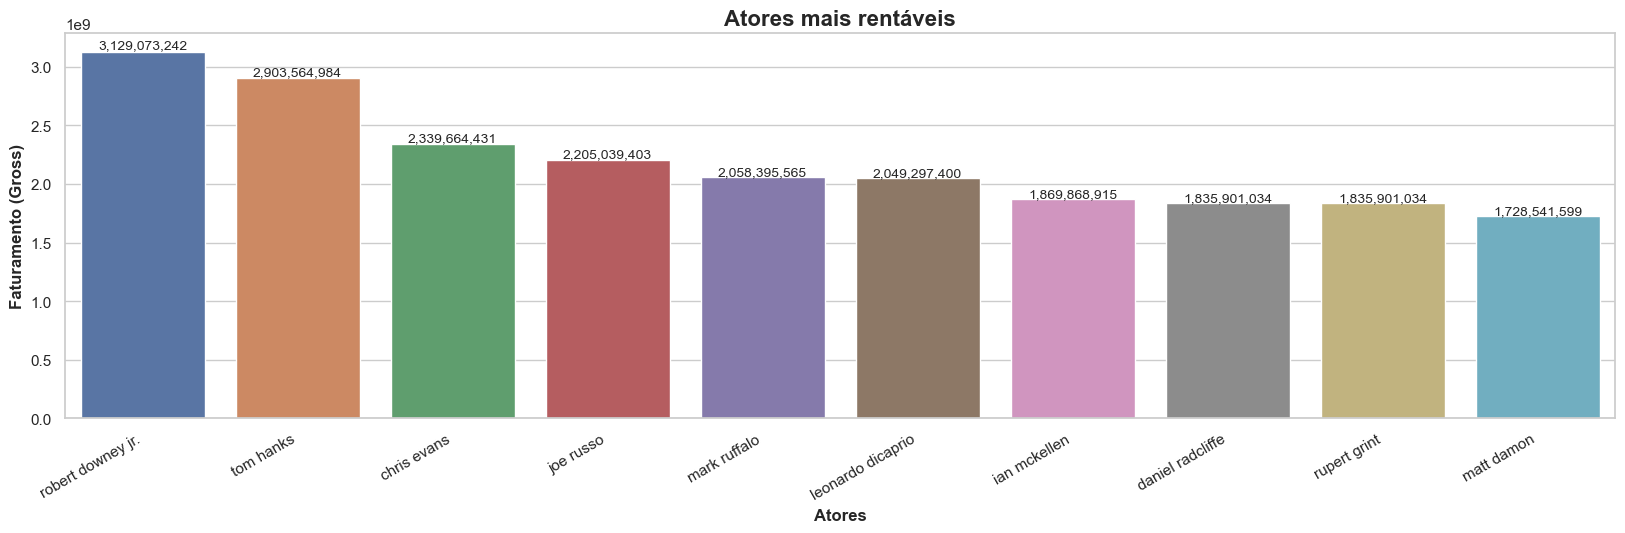

In [34]:
star_gross = defaultdict(float)
for star_col in stars:
    temp = imdb_oscar[[star_col, 'Gross']].dropna()
    for _, row in temp.iterrows():
        star_gross[row[star_col]] += row['Gross']

top_stars = dict(sorted(star_gross.items(), key=lambda item: item[1], reverse=True)[:10])
names = list(top_stars.keys())
gross_values = list(top_stars.values())

fig, axs = plt.subplots(figsize=(20,5))

g = sns.barplot(
    x=names,
    y=gross_values,
    hue=names,  
    dodge=False,
    legend=False
)

g.set_title("Atores mais rentáveis", weight="bold", fontsize=16)
g.set_xlabel("Atores", fontsize=12, weight="bold")
g.set_ylabel("Faturamento (Gross)", fontsize=12, weight="bold")

for index, value in enumerate(gross_values):
    g.text(index, value + value*0.01, f"{int(value):,}", ha='center', fontsize=10)

plt.xticks(rotation=30, ha='right')

plt.show()

#### Distribuições

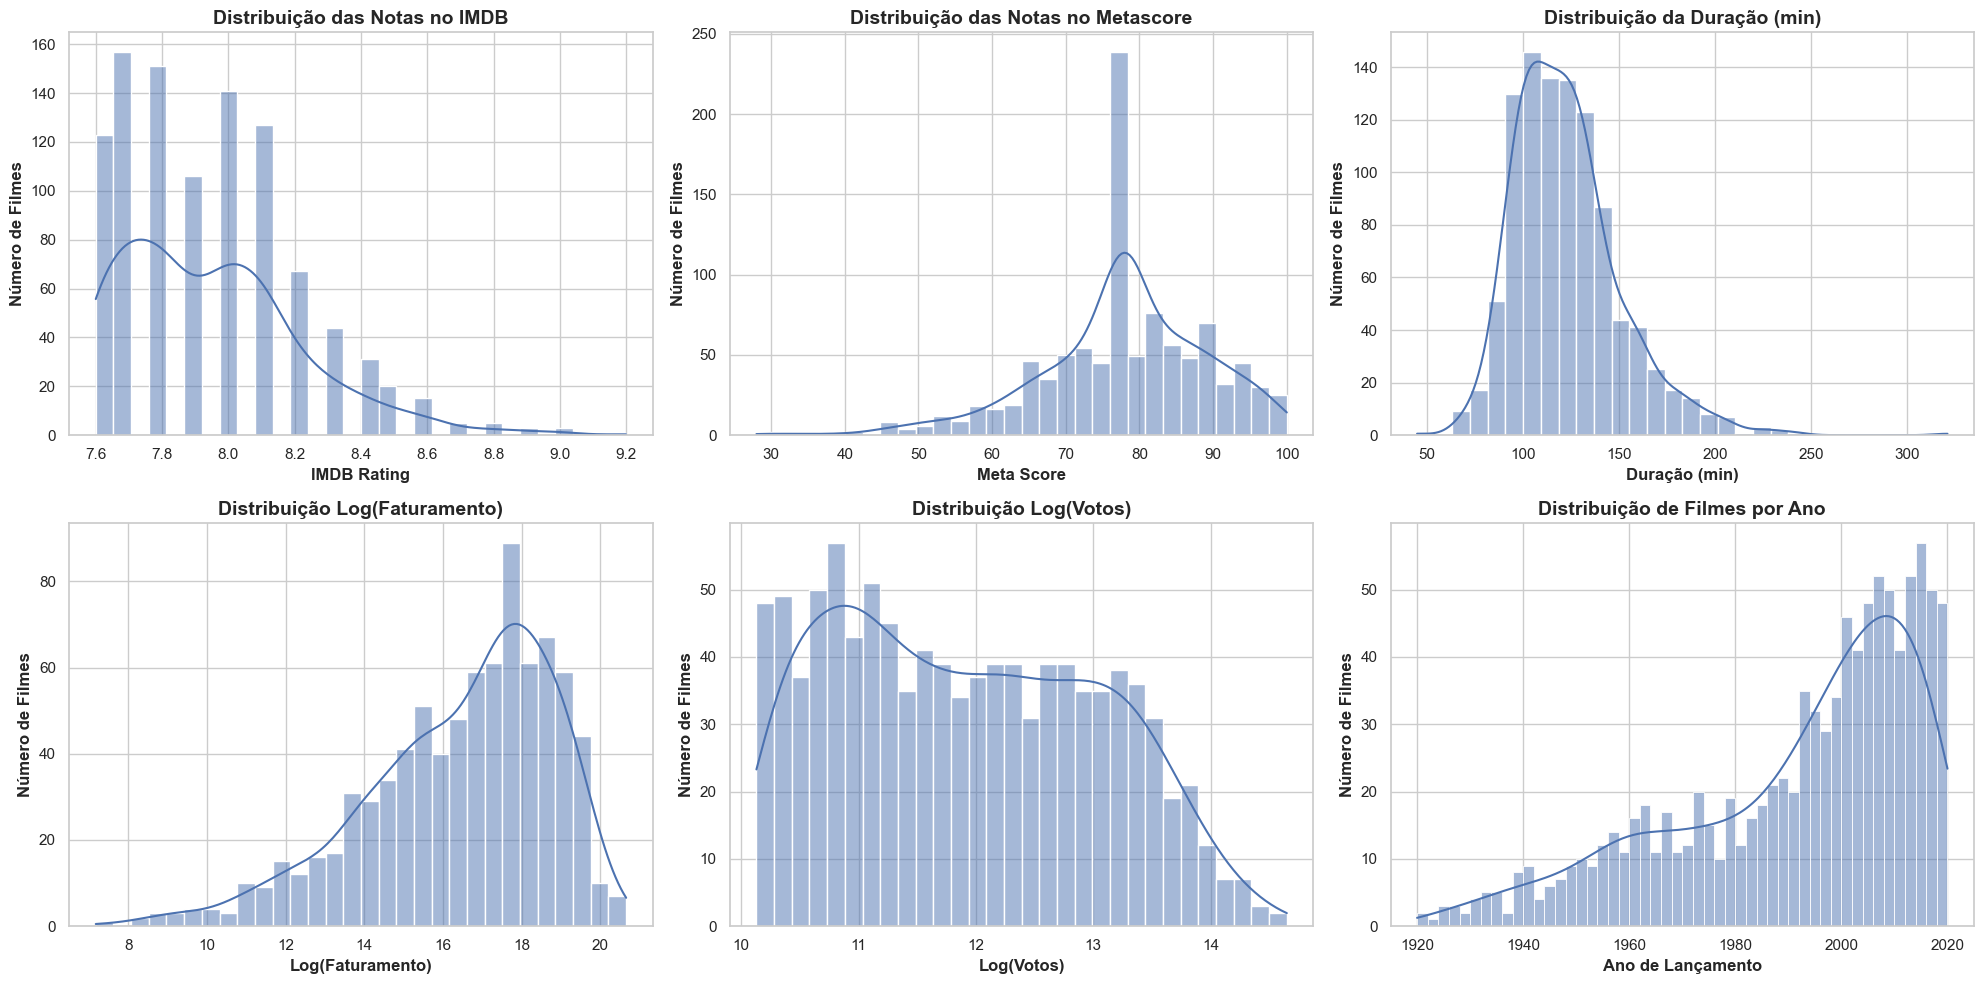

In [35]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

sns.histplot(imdb_oscar['IMDB_Rating'], bins=30, kde=True, ax=axs[0,0])
axs[0,0].set_title("Distribuição das Notas no IMDB", weight="bold", fontsize=14)
axs[0,0].set_xlabel("IMDB Rating", fontsize=12, weight="bold")
axs[0,0].set_ylabel("Número de Filmes", fontsize=12, weight="bold")

sns.histplot(imdb_oscar['Meta_score'].dropna(), bins=30, kde=True, ax=axs[0,1])
axs[0,1].set_title("Distribuição das Notas no Metascore", weight="bold", fontsize=14)
axs[0,1].set_xlabel("Meta Score", fontsize=12, weight="bold")
axs[0,1].set_ylabel("Número de Filmes", fontsize=12, weight="bold")

sns.histplot(imdb_oscar['Runtime'].dropna(), bins=30, kde=True, ax=axs[0,2])
axs[0,2].set_title("Distribuição da Duração (min)", weight="bold", fontsize=14)
axs[0,2].set_xlabel("Duração (min)", fontsize=12, weight="bold")
axs[0,2].set_ylabel("Número de Filmes", fontsize=12, weight="bold")

sns.histplot(np.log(imdb_oscar.loc[imdb_oscar['Gross'] > 0, 'Gross']), bins=30, kde=True, ax=axs[1,0])
axs[1,0].set_title("Distribuição Log(Faturamento)", weight="bold", fontsize=14)
axs[1,0].set_xlabel("Log(Faturamento)", fontsize=12, weight="bold")
axs[1,0].set_ylabel("Número de Filmes", fontsize=12, weight="bold")

sns.histplot(np.log(imdb_oscar.loc[imdb_oscar['No_of_Votes'] > 0, 'No_of_Votes']), bins=30, kde=True, ax=axs[1,1])
axs[1,1].set_title("Distribuição Log(Votos)", weight="bold", fontsize=14)
axs[1,1].set_xlabel("Log(Votos)", fontsize=12, weight="bold")
axs[1,1].set_ylabel("Número de Filmes", fontsize=12, weight="bold")

sns.histplot(imdb_oscar['Released_Year'], bins=50, kde=True, ax=axs[1,2])
axs[1,2].set_title("Distribuição de Filmes por Ano", weight="bold", fontsize=14)
axs[1,2].set_xlabel("Ano de Lançamento", fontsize=12, weight="bold")
axs[1,2].set_ylabel("Número de Filmes", fontsize=12, weight="bold")

plt.tight_layout()
plt.show()


### Análise de correlações

#### Correlações por grupo no Oscar

In [36]:
numeric_cols = ['IMDB_Rating','Meta_score','Gross','No_of_Votes','Runtime']

for status in oscar_order:
    print(f"\n {status.upper()} ")
    subset = imdb_oscar[imdb_oscar['Oscar_Film']==status][numeric_cols]
    corr_matrix = subset.corr()
    
    strong_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i,j]
            if abs(corr_val) > 0.3 and not pd.isna(corr_val):
                strong_corr.append((corr_matrix.columns[i], 
                                  corr_matrix.columns[j], 
                                  corr_val))
    
    if strong_corr:
        for col1, col2, corr in sorted(strong_corr, key=lambda x: abs(x[2]), reverse=True):
            print(f"  {col1} X {col2}: {corr:.3f}")
    else:
        print("  Nenhuma correlação forte encontrada")


 NO 
  Gross X No_of_Votes: 0.617
  IMDB_Rating X No_of_Votes: 0.360

 NOMINATED 
  IMDB_Rating X No_of_Votes: 0.623
  Gross X No_of_Votes: 0.594

 WON 
  IMDB_Rating X No_of_Votes: 0.756
  Gross X No_of_Votes: 0.585


##### Insights:
- A correlação IMDB_Rating X No_of_Votes cresce progressivamente de No (0,36) → Nominated (0,62) → Won (0,76).
    - À medida que o filme progride no Oscar, a percepção do público se torna um fator mais relevante para o engajamento.
- A correlação Gross X No_of_Votes é consistente (0,58–0,62), mostrando que bilheteria sempre influencia o engajamento, mas seu efeito não aumenta tanto quanto a avaliação do público.
- Para vencedores do Oscar, a nota do público é o fator mais relacionado ao reconhecimento e engajamento, enquanto a bilheteria é importante, mas secundária.

#### Correlações Gerais

In [37]:
print(imdb_oscar[['IMDB_Rating', 'Meta_score', 'No_of_Votes', 'Gross','Runtime']].corr())

             IMDB_Rating  Meta_score  No_of_Votes     Gross   Runtime
IMDB_Rating     1.000000    0.256122     0.479308  0.084753  0.242751
Meta_score      0.256122    1.000000    -0.019238 -0.052157 -0.027926
No_of_Votes     0.479308   -0.019238     1.000000  0.616345  0.172483
Gross           0.084753   -0.052157     0.616345  1.000000  0.144153
Runtime         0.242751   -0.027926     0.172483  0.144153  1.000000


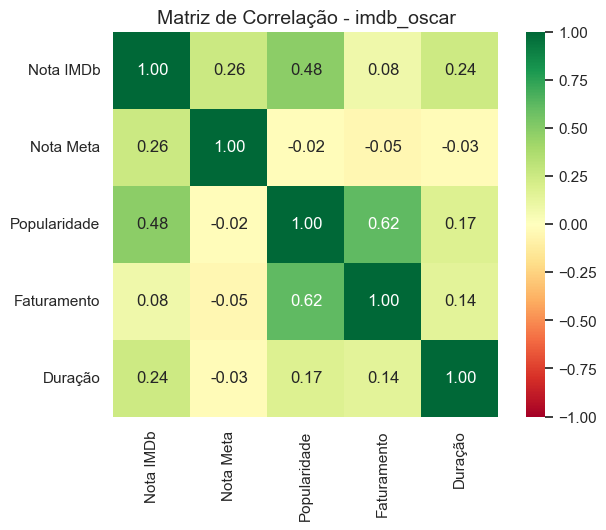

In [38]:
cols = ["IMDB_Rating", "Meta_score", "No_of_Votes", "Gross", "Runtime"]
rename_dict = {
    "IMDB_Rating": "Nota IMDb",
    "Meta_score": "Nota Meta",
    "No_of_Votes": "Popularidade",
    "Gross": "Faturamento",
    "Runtime": "Duração"
}
corr_matrix = imdb_oscar[cols].corr().rename(index=rename_dict, columns=rename_dict)

plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap="RdYlGn", vmin=-1, vmax=1, square=True, fmt=".2f")
plt.title("Matriz de Correlação - imdb_oscar", fontsize=14)
plt.show()

##### A partir dessas informações, temos:
- Nota Meta X Popularidade: relação muito fraca - críticas especializadas não influenciam a popularidade dos filmes
- Nota IMDb X Faturamento: uma nota boa no IMDb não garante bilheteria elevada
- Notas IMDb X Meta: relação muito fraca
- Runtime X Nota IMDB: relação fraca — filmes mais longos tendem a ter avaliações ligeiramente melhores
- Nota IMDb X Popularidade: relação moderada — filmes bem avaliados têm chance moderadamente maior de serem mais populares
- Popularidade X Faturamento: relação moderada/forte — a variância é de aproximadamente 38%, ou seja, 38% da variação do faturamento pode ser explicada apenas pelo número de votos

##### Insights:
- A popularidade tem ligação com o faturamento e com as avaliações do IMDb, separadamente
- As críticas do Meta não apresentam relações diretas com nenhum dos outros fatores analisados
- Filmes mais longos apresentam ligeira tendência a ter melhores avaliações no IMDb, mas o efeito é fraco

##### Possíveis vieses da base: 
- Tempo desde o lançamento — filmes mais antigos tiveram mais tempo de acumular críticas, bilheteria e votos

Se optarmos por modelar uma **regressão** a partir do logarítimo do faturamento, temos:

In [39]:
import statsmodels.formula.api as smf

df = imdb_oscar.copy()
df["Gross"] = df["Gross"].replace(0, np.nan)
df["No_of_Votes"] = df["No_of_Votes"].replace(0, np.nan)

m = smf.ols(
    formula="np.log(Gross) ~ np.log(No_of_Votes) + IMDB_Rating + Meta_score + Runtime",
    data=df
).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(Gross)   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     218.7
Date:                Thu, 04 Sep 2025   Prob (F-statistic):          6.64e-128
Time:                        18:16:25   Log-Likelihood:                -1607.9
No. Observations:                 830   AIC:                             3226.
Df Residuals:                     825   BIC:                             3249.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              16.9862    

##### A partir desses dados, temos:
- Esse modelo explica 51% da variação do faturamento
- Pode apresentar problemas de multicolinearidade
- Um aumento de 1% no número de votos está associado a um aumento de 1.7% no faturamento.
- Um aumento de 1 ponto de nota IMDb está associado a uma queda de 2.96 unidades no log do faturamento
    - Filmes com boas avaliações tendem a faturar menos, ou seja, filmes filmes bem avaliados acabam sendo filmes nichados
 
##### Insights:
- O número de votos é o principal preditor do faturamento
- Fatores externos (marketing, elenco, etc) influenciam significativamente a outra metade da bilheteria (49%)

#### Gráficos:

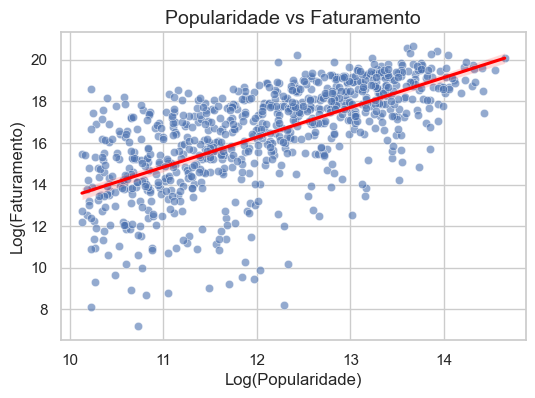

In [40]:
df = imdb_oscar.copy()
df = df.replace(0, np.nan).dropna(subset=["Gross","No_of_Votes","IMDB_Rating","Meta_score","Runtime"])

df["logGross"] = np.log(df["Gross"])
df["pred"] = m.fittedvalues
df["resid"] = m.resid

plt.figure(figsize=(6,4))
sns.scatterplot(x=np.log(df["No_of_Votes"]), y=df["logGross"], alpha=0.6)
sns.regplot(x=np.log(df["No_of_Votes"]), y=df["logGross"], scatter=False, color="red")
plt.xlabel("Log(Popularidade)")
plt.ylabel("Log(Faturamento)")
plt.title("Popularidade vs Faturamento")
plt.show()

- Mostra relação linear forte entre log(votos) e log(faturamento)
- R² visual elevado - pontos seguem bem a linha de tendência
##### Mais engajamento = Mais dinheiro

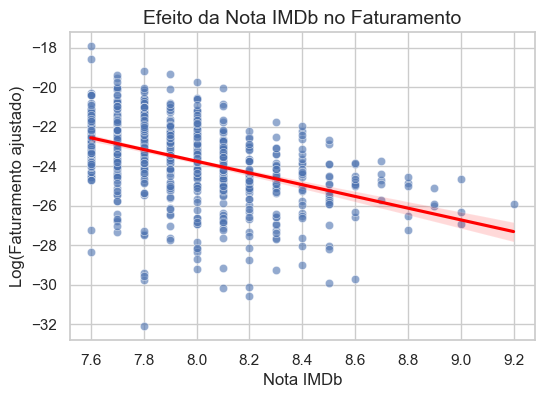

In [41]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=df["IMDB_Rating"], y=df["resid"] + df["IMDB_Rating"]*m.params["IMDB_Rating"], alpha=0.6)
sns.regplot(x=df["IMDB_Rating"], y=df["resid"] + df["IMDB_Rating"]*m.params["IMDB_Rating"], scatter=False, color="red")
plt.xlabel("Nota IMDb")
plt.ylabel("Log(Faturamento ajustado)")
plt.title("Efeito da Nota IMDb no Faturamento")
plt.show()

- Inclinação negativa confirma o paradoxo de um aumento de 1 ponto de nota IMDb estar associado a uma queda de 2.68 unidades no log do faturamento
    - Controlando por popularidade, filmes "melhores" faturam menos

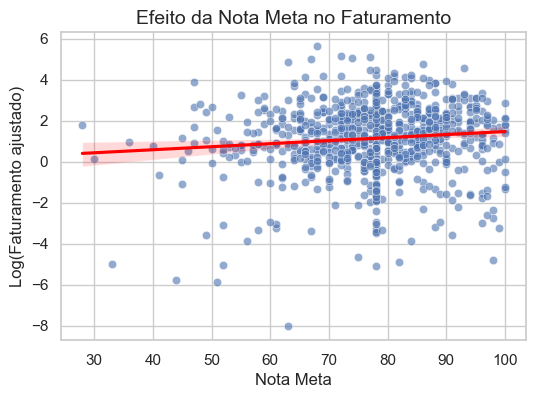

In [42]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=df["Meta_score"], y=df["resid"] + df["Meta_score"]*m.params["Meta_score"], alpha=0.6)
sns.regplot(x=df["Meta_score"], y=df["resid"] + df["Meta_score"]*m.params["Meta_score"], scatter=False, color="red")
plt.xlabel("Nota Meta")
plt.ylabel("Log(Faturamento ajustado)")
plt.title("Efeito da Nota Meta no Faturamento")
plt.show()

- Inclinação positiva suave
    - Críticos reconhecem valor comercial sutilmente
##### Insight: Equilíbrio entre crítica e público

### Tendências

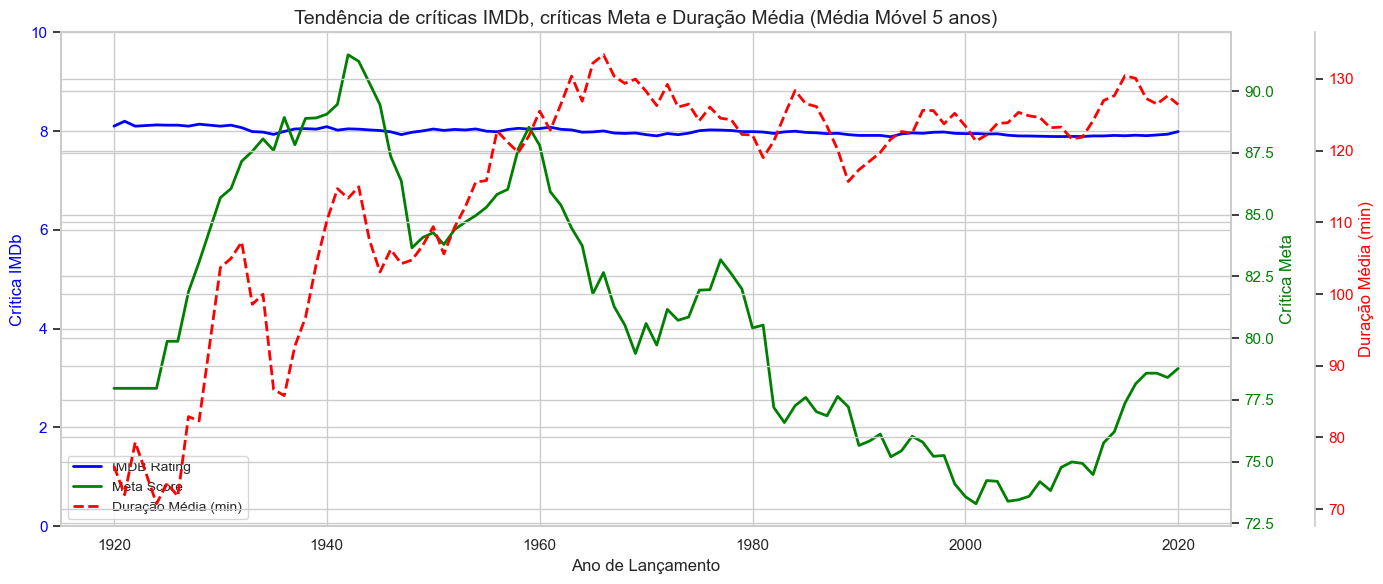

In [43]:
tendencias = imdb_oscar.groupby('Released_Year')[['IMDB_Rating','Meta_score','Runtime']].mean()

tendencias = tendencias.rolling(window=5, min_periods=1).mean()

fig, ax1 = plt.subplots(figsize=(14,6))

ax1.plot(tendencias.index, tendencias['IMDB_Rating'], color='blue', linewidth=2, label='IMDB Rating')
ax1.set_xlabel('Ano de Lançamento', fontsize=12)
ax1.set_ylabel('Crítica IMDb', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 10)
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(tendencias.index, tendencias['Meta_score'], color='green', linewidth=2, label='Meta Score')
ax2.set_ylabel('Crítica Meta', color='green', fontsize=12)
ax2.tick_params(axis='y', labelcolor='green')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(tendencias.index, tendencias['Runtime'], color='red', linewidth=2, linestyle='--', label='Duração Média (min)')
ax3.set_ylabel('Duração Média (min)', color='red', fontsize=12)
ax3.tick_params(axis='y', labelcolor='red')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='lower left')

plt.title('Tendência de críticas IMDb, críticas Meta e Duração Média (Média Móvel 5 anos)', fontsize=14)
plt.tight_layout()
plt.show()


##### Insights:
- A avaliação do público (IMDb) é estável, independente de mudanças na crítica ou duração
- A crítica especializada (Meta) mostra grande oscilação ao longo das décadas, possivelmente refletindo mudanças de estilo cinematográfico ou preferências da crítica
- Filmes mais longos tendem a aparecer nos períodos mais recentes, talvez indicando preferência da indústria por narrativas mais densas ou épicas.
- Não há uma relação direta clara entre a duração média e a avaliação do público — filmes mais longos não implicam automaticamente em notas maiores no IMDb.

#### Melhores combinações de Diretor X Ator

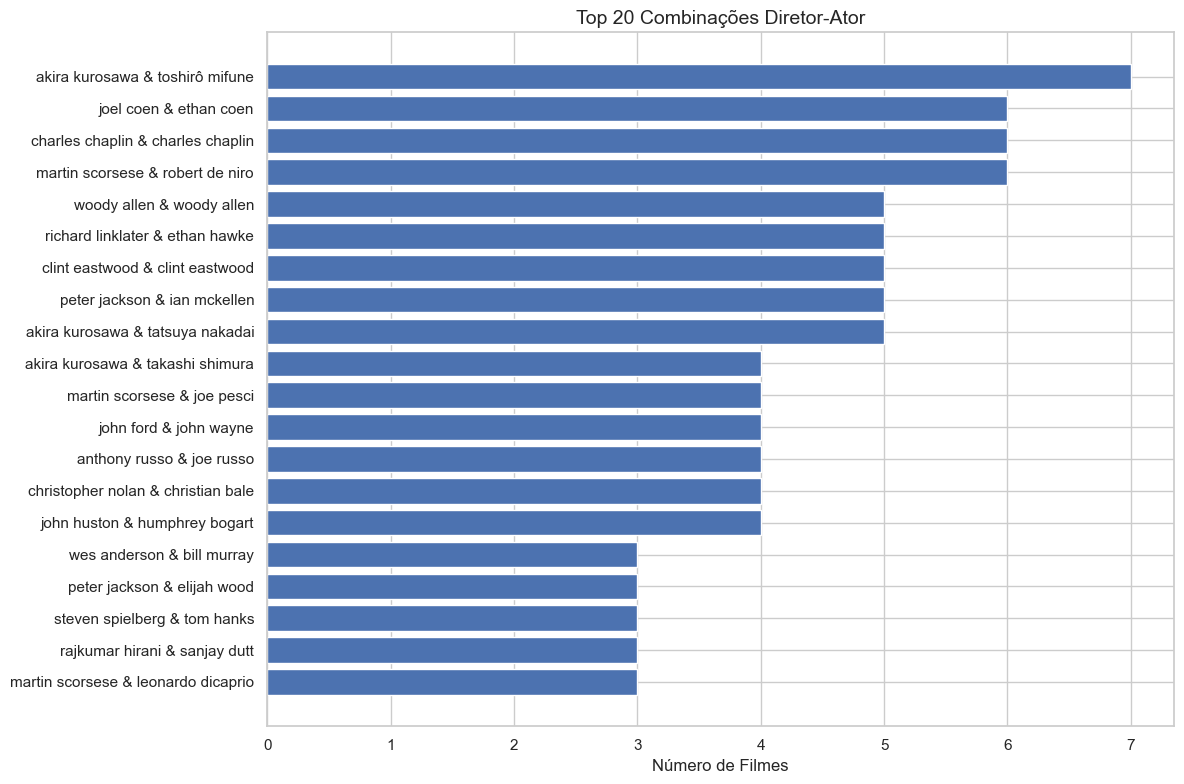

In [44]:
combinacao = []
for _, row in imdb_oscar.iterrows():
    director = row['Director']
    for star_col in ['Star1','Star2','Star3','Star4']:
        if pd.notna(row[star_col]):
            combinacao.append((director, row[star_col]))

combo_counts = pd.Series(combinacao).value_counts().head(20)

combo_labels = combo_counts.index.map(lambda x: f"{x[0]} & {x[1]}")

plt.figure(figsize=(12,8))
plt.barh(combo_labels[::-1], combo_counts.values[::-1])
plt.xlabel('Número de Filmes')
plt.title('Top 20 Combinações Diretor-Ator')
plt.tight_layout()
plt.show()

### Clusters

In [47]:
cluster_features = ['IMDB_Rating', 'Meta_score', 'Runtime', 'Released_Year']
for col in cluster_features:
    imdb_oscar[col] = pd.to_numeric(imdb_oscar[col], errors='coerce')

X = imdb_oscar[cluster_features].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

imdb_clustered = imdb_oscar.loc[X.index].copy()
imdb_clustered['Cluster'] = clusters

imdb_clustered['Oscar_Film_Num'] = imdb_clustered['Oscar_Film'].map({
    'Won': 1,
    'Nominated': 0.5,
    'No': 0
})

imdb_clustered['Gross_Num'] = pd.to_numeric(
    imdb_clustered['Gross'].astype(str).str.replace(r'[^\d.]', '', regex=True), 
    errors='coerce'
)

cluster_analysis = imdb_clustered.groupby('Cluster').agg({
    'IMDB_Rating': 'mean',
    'Meta_score': 'mean',
    'Runtime': 'mean',
    'Gross_Num': 'mean',
    'Oscar_Film_Num': 'mean'
}).round(2)

print(cluster_analysis)

         IMDB_Rating  Meta_score  Runtime    Gross_Num  Oscar_Film_Num
Cluster                                                               
0               7.99       86.13   108.10  19246291.19            0.17
1               8.23       79.41   151.97  73458885.14            0.22
2               7.79       73.58   115.45  65231452.28            0.09


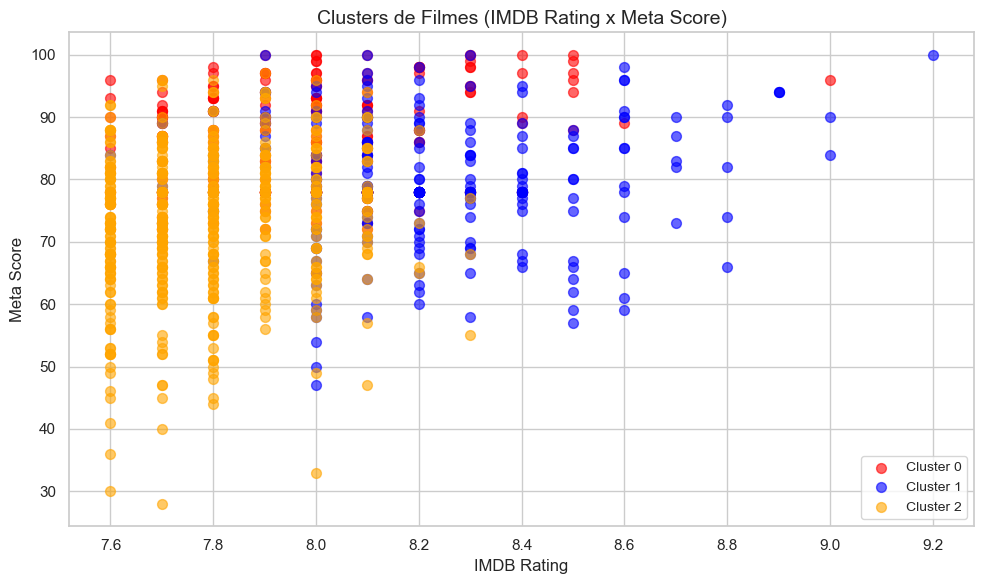

In [48]:
colors = ['red', 'blue', 'orange']

plt.figure(figsize=(10,6))
for cluster_id in sorted(imdb_clustered['Cluster'].unique()):
    cluster_data = imdb_clustered[imdb_clustered['Cluster'] == cluster_id]
    plt.scatter(cluster_data['IMDB_Rating'], 
                cluster_data['Meta_score'], 
                s=50, 
                color=colors[cluster_id], 
                label=f'Cluster {cluster_id}', alpha=0.6)

plt.xlabel('IMDB Rating', fontsize=12)
plt.ylabel('Meta Score', fontsize=12)
plt.title('Clusters de Filmes (IMDB Rating x Meta Score)', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### Cluster 0:
- Crítica alta em ambas as críticas.
- Filmes de curta duração.
- Receita baixa.
- Chance de Oscar moderada (0.17)

##### Cluster 1:
- Crítica maior no IMDb, mas menos no Meta.
- Filmes de maior duração.
- A maior receita entre os clusters.
- Chance de Oscar moderada (0.22).

##### Cluster 2:
- Críticas mais baixas.
- Filmes com duração média.
- Receita alta.
- Poucos Oscars (0.09)

#### Insights:
- Cluster 0 se destaca em crítica, mas tem baixo retorno financeiro e curta duração.
- Cluster 1 se destaca em popularidade e receita, filmes longos e bem avaliados.
- Cluster 2 representa filmes mais medianos, com avaliação e premiação inferiores, mas receita razoável.

-------

## Parte 2: Perguntas

-----

### Qual filme você recomendaria para uma pessoa que você não conhece?

In [49]:
def recomendar_filme(df):
    top_films = df[
        (df['IMDB_Rating'] >= 8.5) &
        (df['Meta_score'] >= 80) &
        (df['Oscar_Film'] == 1)
    ].sort_values(by='No_of_Votes', ascending=False)

    if top_films.empty:
        top_films = df[
            (df['IMDB_Rating'] >= 8) &
            (df['Meta_score'] >= 70)
        ].sort_values(by='No_of_Votes', ascending=False)

    if top_films.empty:
        top_films = df.sort_values(by='No_of_Votes', ascending=False)

    recommended_film = top_films.iloc[0]['Series_Title']
    return recommended_film

filme_recomendado = recomendar_filme(imdb_oscar)
print("Filme recomendado:", filme_recomendado)

Filme recomendado: The Dark Knight


### Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme? 

In [50]:
df = imdb_oscar.copy()

def extract_genres(df): 
    all_genres = [] 
    for genre_list in df['Genre'].dropna(): 
        genres = [g.strip() for g in genre_list.split(',')] 
        all_genres.extend(genres) 
    return pd.Series(all_genres).value_counts() 

imdb_oscar['Gênero_Principal'] = imdb_oscar['Genre'].str.split(',').str[0].str.strip()

genre_performance = imdb_oscar.groupby('Gênero_Principal').agg({
    'IMDB_Rating': ['mean', 'count'],
    'Meta_score': 'mean',
    'Gross': ['mean', 'median'],
    'Oscar_Film': 'sum'
}).round(2)

fatores = ['Gênero_Principal', 'IMDB_Rating', 'Meta_score', 'Runtime', 
           'Oscar_Film', 'Director_Oscar', 'Star1_Oscar', 'Star2_Oscar',
           'Star3_Oscar', 'Star4_Oscar', 'No_of_Votes', 'Released_Year']

corr = df[['Gross', 'IMDB_Rating', 'Meta_score', 'Runtime', 'No_of_Votes']].corr()
print("Correlação com Gross:\n", corr['Gross'].sort_values(ascending=False))

Correlação com Gross:
 Gross          1.000000
No_of_Votes    0.616345
Runtime        0.144153
IMDB_Rating    0.084753
Meta_score    -0.052157
Name: Gross, dtype: float64


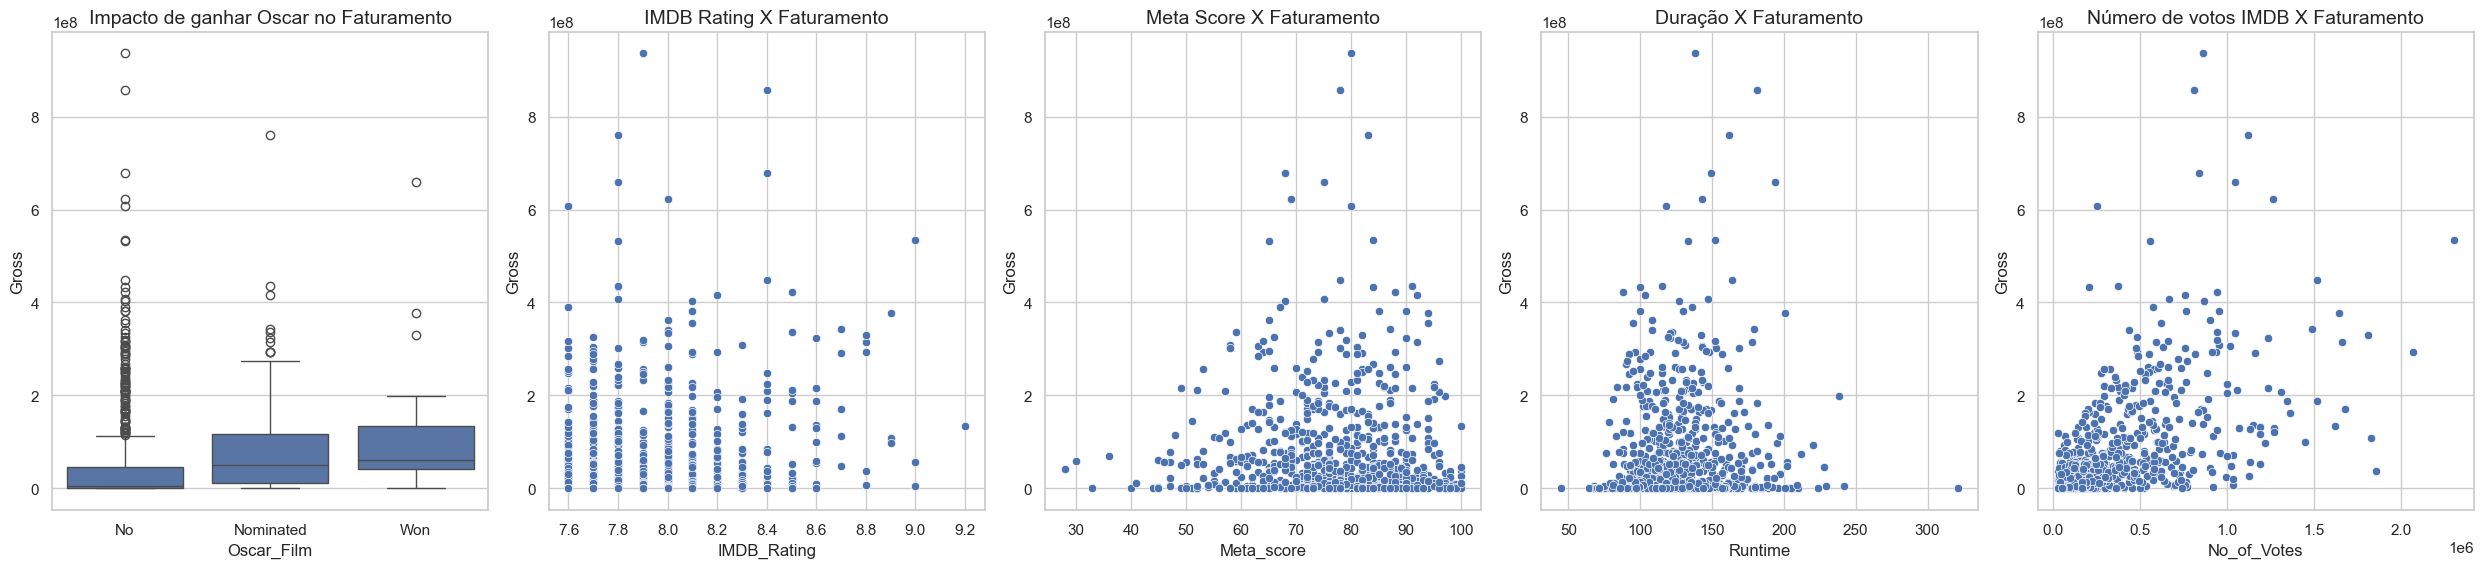

In [51]:
fig, axs = plt.subplots(1, 5, figsize=(25, 6))  # 1 linha, 5 colunas

sns.boxplot(x='Oscar_Film', y='Gross', data=df, order=oscar_order, ax=axs[0])
axs[0].set_title('Impacto de ganhar Oscar no Faturamento')

sns.scatterplot(x='IMDB_Rating', y='Gross', data=df, ax=axs[1])
axs[1].set_title('IMDB Rating X Faturamento')

sns.scatterplot(x='Meta_score', y='Gross', data=df, ax=axs[2])
axs[2].set_title('Meta Score X Faturamento')

sns.scatterplot(x='Runtime', y='Gross', data=df, ax=axs[3])
axs[3].set_title('Duração X Faturamento')

sns.scatterplot(x='No_of_Votes', y='Gross', data=df, ax=axs[4])
axs[4].set_title('Número de votos IMDB X Faturamento')

plt.tight_layout()
plt.show()


Correlação de Gross com variáveis numéricas:

Gross          1.000000
No_of_Votes    0.616345
Runtime        0.144153
IMDB_Rating    0.084753
Meta_score    -0.052157
Name: Gross, dtype: float64




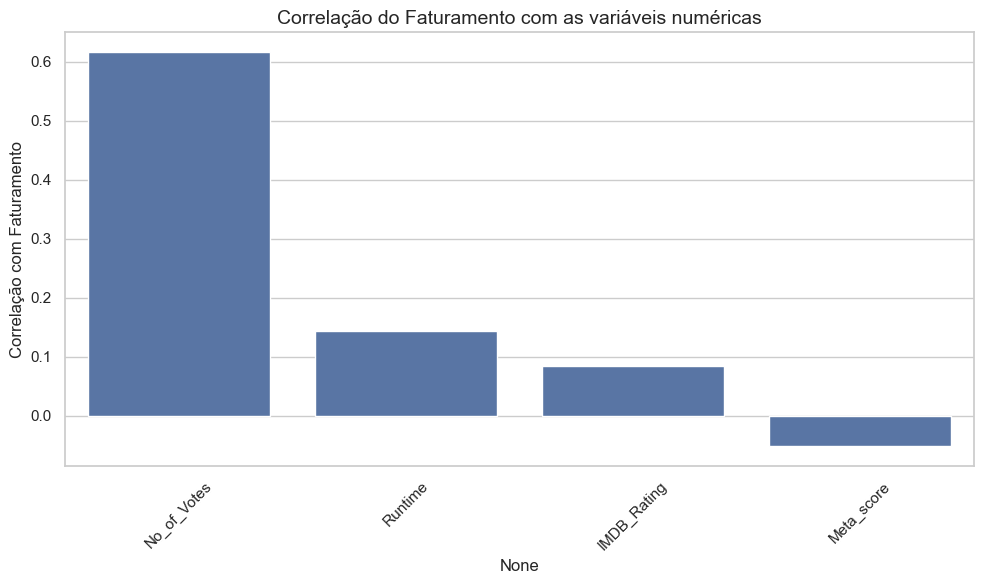

In [62]:
numeric_cols = ['No_of_Votes', 'Runtime', 'IMDB_Rating', 'Meta_score']
corr_gross = imdb_oscar[numeric_cols + ['Gross']].corr()['Gross'].sort_values(ascending=False)
print("Correlação de Gross com variáveis numéricas:\n")
print(corr_gross)
print("\n" + "="*50 + "\n")

plt.figure()
sns.barplot(x=corr_gross.index[1:], y=corr_gross.values[1:])
plt.title("Correlação do Faturamento com as variáveis numéricas")
plt.ylabel("Correlação com Faturamento")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [63]:
categorical_cols = ['Gênero_Principal', 'Oscar_Film', 'Director_Oscar']

print("\nMédia de Faturamento por categoria (top 5):\n")
for col in categorical_cols:
    top_gross = df.groupby(col)['Gross'].mean().sort_values(ascending=False).head(5)
    print(f"{col}:\n{top_gross}\n")


Média de Faturamento por categoria (top 5):

Gênero_Principal:
Gênero_Principal
Family       2.195553e+08
Action       1.163767e+08
Animation    1.045588e+08
Adventure    7.324659e+07
Horror       6.689616e+07
Name: Gross, dtype: float64

Oscar_Film:
Oscar_Film
Won          9.618803e+07
Nominated    8.577615e+07
No           4.732952e+07
Name: Gross, dtype: float64

Director_Oscar:
Director_Oscar
Won          1.065827e+08
Nominated    6.334095e+07
No           4.987503e+07
Name: Gross, dtype: float64



- Popularidade do público (No_of_Votes)
    - Filmes com mais votos tendem a ter maior bilheteria.
- Gênero do filme (Gênero_Principal)
    - Family: US 219,555,300
    - Action: US 116,376,700
    - Animation: US 104,558,800
    - Filmes familiares, de ação ou animação têm maior expectativa de faturamento, por atingir amplo público.
- Premiações do filme (Oscar_Film)
    - Filmes premiados ou indicados ao Oscar apresentam faturamento médio maior devido à visibilidade e prestígio.
- Premiações do diretor (Director_Oscar)
    - Diretores premiados aumentam a expectativa de faturamento por trazerem credibilidade e atratividade ao filme.
- Duração do filme (Runtime)
    - Filmes mais longos podem ter leve vantagem, mas o efeito é pequeno.
- Avaliação do público (IMDB_Rating)
    - Nota média quase não impacta a bilheteria.
- Avaliação da crítica (Meta_score)
    - Avaliações críticas têm efeito mínimo ou inexistente sobre o faturamento.

### Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?

A partir da coluna Overview, o pequeno súmario mostra palavras chaves do filme. Além disso, com essas palavras, podemos identificar sentimentos que o público pode esperar a também definir o gênero. 

##### Definindo o gênero do filme a partir da coluna Overview
Lista de Gêneros existentes:

In [56]:
generos_primarios = imdb_oscar['Gênero_Principal'].dropna().unique().tolist()
print(generos_primarios)

['Crime', 'Action', 'Biography', 'Drama', 'Western', 'Comedy', 'Adventure', 'Animation', 'Horror', 'Mystery', 'Film-Noir', 'Fantasy', 'Family', 'Thriller']


Criando um modelo que preve a categoria a partir das palavras mais usadas em cada categoria:

In [57]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    words = text.lower().split()
    words = [w.strip(".,!?()[]") for w in words if w not in stop_words and len(w) > 2]
    words = [lemmatizer.lemmatize(w) for w in words]
    return words

top_palavras_genero = {}
for genre in imdb_oscar['Gênero_Principal'].dropna().unique():
    subset = imdb_oscar[imdb_oscar['Gênero_Principal'] == genre]
    all_text = " ".join(desc for desc in subset['Overview'].dropna())
    words = preprocess(all_text)
    word_counts = Counter(words)
    top_palavras_genero[genre] = [w for w,_ in word_counts.most_common(50)]

def suggest_genre(text):
    words = preprocess(text)
    genre_scores = {}
    for genre, keywords in top_palavras_genero.items():
        score = sum(words.count(kw) for kw in keywords)
        genre_scores[genre] = score
    suggested = max(genre_scores, key=genre_scores.get)
    if genre_scores[suggested] == 0:
        return 'Unknown'
    return suggested

imdb_oscar['Previsao'] = imdb_oscar['Overview'].apply(suggest_genre)

imdb_oscar['Acertos'] = imdb_oscar['Gênero_Principal'] == imdb_oscar['Previsao']

precisao = imdb_oscar['Acertos'].mean()
print(f"Precisão na previsão do gênero: {precisao:.2%}")

counts = imdb_oscar['Acertos'].value_counts()
print("\nContagem de previsões corretas/erradas:")
print(counts)

precisao_genero = imdb_oscar.groupby('Gênero_Principal')['Acertos'].mean().sort_values(ascending=False)
print("\nPrecisão na Previsao do gênero principal:")
print(precisao_genero)

print("\nExemplo de previsões:")
print(imdb_oscar[['Series_Title', 'Gênero_Principal', 'Previsao']].head(20))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Marina\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Marina\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Precisão na previsão do gênero: 45.45%

Contagem de previsões corretas/erradas:
Acertos
False    545
True     454
Name: count, dtype: int64

Precisão na Previsao do gênero principal:
Gênero_Principal
Fantasy      1.000000
Thriller     1.000000
Western      1.000000
Film-Noir    1.000000
Family       1.000000
Mystery      0.750000
Crime        0.710280
Adventure    0.541667
Biography    0.511364
Action       0.488372
Horror       0.454545
Animation    0.390244
Comedy       0.361290
Drama        0.333333
Name: Acertos, dtype: float64

Exemplo de previsões:
                                         Series_Title Gênero_Principal  \
0                                       The Godfather            Crime   
1                                     The Dark Knight           Action   
2                              The Godfather: Part II            Crime   
3                                        12 Angry Men            Crime   
4       The Lord of the Rings: The Return of the King           Actio

Para melhorar a chance de acerto, já que a precisão esta em 45.45%, vamos ampliar esse modelo para sugerir 3 gêneros para cada filme

In [58]:
def preprocess(text):
    return " ".join([w for w in text.lower().split() if w not in stop_words])

df = imdb_oscar.dropna(subset=['Overview', 'Gênero_Principal']).copy()
df['Overview_clean'] = df['Overview'].apply(preprocess)

genre_counts = df['Gênero_Principal'].value_counts()
df_filtered = df[df['Gênero_Principal'].isin(genre_counts[genre_counts >= 2].index)]

X_train, X_test, y_train, y_test = train_test_split(
    df_filtered['Overview_clean'], df_filtered['Gênero_Principal'], 
    test_size=0.2, random_state=42, stratify=df_filtered['Gênero_Principal']
)

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

model = LogisticRegression(max_iter=1000, multi_class='multinomial')
model.fit(X_train_tfidf, y_train)

def get_top3_predictions(X_tfidf):
    probs = model.predict_proba(X_tfidf)
    top3_idx = probs.argsort(axis=1)[:, -3:][:, ::-1]
    return [[model.classes_[i] for i in row] for row in top3_idx]

top3_test = get_top3_predictions(X_test_tfidf)
df_test = pd.DataFrame({
    'Overview': X_test,
    'Gênero_Principal': y_test,
    'Top3_Generos': top3_test
})
print("Exemplos de previsões na divisão de teste:")
print(df_test.head(10))

X_all_tfidf = vectorizer.transform(df_filtered['Overview_clean'])
top3_all = get_top3_predictions(X_all_tfidf)

df_all = df_filtered.copy()
df_all['Top3_Generos'] = top3_all
df_all['corretos_top3'] = df_all.apply(
    lambda row: row['Gênero_Principal'] in row['Top3_Generos'], axis=1
)

top3_precisao = df_all['corretos_top3'].mean()
print(f"\nTop-3 Precisão em toda a base: {top3_precisao:.2%}")
print(f"Acertos: {df_all['corretos_top3'].sum()}, Erros: {(~df_all['corretos_top3']).sum()}")

print("\nTop-3 Precisão por gênero:")
print(df_all.groupby('Gênero_Principal')['corretos_top3'].mean().sort_values(ascending=False))

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Exemplos de previsões na divisão de teste:
                                              Overview Gênero_Principal  \
44   filmmaker recalls childhood falling love pictu...            Drama   
678  high school wise guy determined day school, de...           Comedy   
460  german youth eagerly enters world war i, enthu...            Drama   
719  year life middle-class family's maid mexico ci...            Drama   
294  senator returns western town funeral old frien...            Drama   
236  nine years jesse celine first met, encounter f...            Drama   
468  set japan, isle dogs follows boy's odyssey sea...        Animation   
722  veteran hunter helps fbi agent investigate mur...            Crime   
403  selfish yuppie charlie babbitt's father left f...            Drama   
97   sexually frustrated suburban father mid-life c...            Drama   

                Top3_Generos  
44   [Drama, Comedy, Action]  
678  [Comedy, Drama, Action]  
460  [Drama, Action, Comedy]  
719  [D

In [59]:
def predict_top3(overview_text, model, vectorizer):
    """Recebe uma sinopse, retorna os 3 gêneros mais prováveis."""
    overview_clean = preprocess(overview_text)
    X_vec = vectorizer.transform([overview_clean])
    probs = model.predict_proba(X_vec)[0]
    classes = model.classes_
    top3_indices = probs.argsort()[-3:][::-1]
    return [classes[i] for i in top3_indices]

new_synopsis = "Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency"

Previsao = predict_top3(new_synopsis, model, vectorizer)

print("Sinopse:", new_synopsis)
print("Top 3 gêneros previstos:", Previsao)


Sinopse: Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency
Top 3 gêneros previstos: ['Drama', 'Action', 'Crime']


----

## Parte 3: Modelo de previsão nota IMDb

----

[código abaixo]

#### Explique como você faria a previsão da nota do imdb a partir dos dados.
Para prever a nota da crítica do IMDb, precisamos seguir o passo a passos de um fluxo de aprendizado supervisionado a partir da regressão.
1) Selecionar variáveis que influenciam a nota no IMDb
2) Pré-processar a partir de técnicas de normalização das variáveis, como StandardScaler para variáveis numéricas e OneHotEncoder para variáveis categóricas
3) Dividir os dados para treino e teste
4) Avaliar a performance a partir desse treinamento
5) Treinar o modelo
6) Avaliar o modelo final com RMSE e R² para medir os possíveis erros de previsão

#### Quais variáveis e/ou suas transformações você utilizou e por quê? 
- Variáveis numéricas (transformação com o StandardScaler - pois ele garante que todas as variáveis numéricas fiquem na mesma escala):
    - Runtime, Meta_score, No_of_Votes, Gross
- Variáveis categóricas (transformação com o OneHotEncoder - pois ele transforma essas variáveis em números binários - o modelo só entende números):
    - Genre, Certificate, Oscar_Film, Director_Oscar, Star1_Oscar, Star2_Oscar, Star3_Oscar, Star4_Oscar
- Variável alvo: IMDB_Rating

#### Qual tipo de problema estamos resolvendo (regressão, classificação)? 
Como estamos lidando com um modelo para prever uma nota (ou seja, um número), o correto é resolver o problema utilizando o sistema de **regressão**.
#### Qual modelo melhor se aproxima dos dados e quais seus prós e contras? 
O melhor modelo é o Random Forest Regressor (RMSE = 0.204, R² = 0.368), que melhor se aplica devido a quantidade de variáveis categóricas que influenciam o modelo.
- Prós: lida melhor com um modelo mais complexo, consegue capturar relações complexas e não lineares e é menos influenciado por outliers
- Contras: menos interpretável, mais lento para treinar e prever, pode overfit se não regularizado adequadamente
#### Qual medida de performance do modelo foi escolhida e por quê?
A medida de performance escolhida para avaliar os modelos foi RMSE (Root Mean Squared Error) e R² (R-squared). O RMSE mostra se temos erros muito grandes no modelo. Quanto menor o RMSE, melhor o modelo está prevendo as notas. Já o R² indica o quão próximo o modelo está de explicar os dados reais, quanto mais alto o R², melhor modelo consegue capturar melhor os padrõe

In [60]:
features_num = ["Runtime", "Meta_score", "No_of_Votes", "Gross"]
features_cat = ["Genre", "Certificate", "Oscar_Film", "Director_Oscar", 
                "Star1_Oscar", "Star2_Oscar", "Star3_Oscar", "Star4_Oscar"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), features_num),
    ("cat", OneHotEncoder(handle_unknown="ignore"), features_cat)
])

X_train, X_test, y_train, y_test = train_test_split(
    imdb_oscar[features_num + features_cat], imdb_oscar["IMDB_Rating"], 
    test_size=0.2, random_state=42
)

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42)
}

for name, model in models.items():
    pipe = Pipeline([("preprocessor", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{name}: RMSE = {rmse:.3f}, R² = {r2:.3f}")

LinearRegression: RMSE = 0.232, R² = 0.180
RandomForest: RMSE = 0.204, R² = 0.368


----

## Parte 4: Previsão nota IMDb para o filme The Shawshank Redemption

----

Para supor essa nota, adicionei as informações correspondentes da Oscar.

In [61]:
rf_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=200, random_state=42))
])
rf_pipe.fit(X_train, y_train)

def predict_movie(movie_data):
    new_df = pd.DataFrame([movie_data])
    new_df['Gross'] = new_df['Gross'].str.replace(",", "").astype(float)
    new_df['Runtime'] = new_df['Runtime'].str.extract(r'(\d+)').astype(float)
    return rf_pipe.predict(new_df[features_num + features_cat])[0]

new_movie = {
    'Certificate': 'A', 'Runtime': '142 min', 'Genre': 'Drama',
    'Meta_score': 80.0, 'No_of_Votes': 2343110, 'Gross': '28,341,469',
    'Oscar_Film': 'Nominated', 'Director_Oscar': 'No', 'Star1_Oscar': 'No',
    'Star2_Oscar': 'Nominated', 'Star3_Oscar': 'No', 'Star4_Oscar': 'No'
}

predicted_rating = predict_movie(new_movie)
print(f"Nota IMDb prevista: {predicted_rating:.2f}")

Nota IMDb prevista: 8.77


# Salvando como .pkl

In [65]:
import nbformat
import pickle

with open("LH_CD_MARINACASTELLANOMULLER.ipynb", "r", encoding="utf-8") as f:
    notebook = nbformat.read(f, as_version=4)

codigo = [cell['source'] for cell in notebook.cells if cell.cell_type == 'code']

with open("LH_CD_MARINACASTELLANOMULLER.pkl", "wb") as f:
    pickle.dump(codigo, f)